<a id='top'></a>
<h1>Table of Contents</h1>
<ol>
    <li><a href="#section1">Project Introduction</a></li>
    <li><a href="#section2">Data Preparation & Cleaning</a></li>
    <ol>
        <li><a href="#section2_1">Columns Removal</a></li>
        <li><a href="#section2_2">Dealing with Missing Data</a></li>
        <li><a href="#section2_3">Dealing with Non-Numeric Columns</a></li>
        <li><a href="#section2_4">Data Quality Check</a></li>
    </ol>    
    <li><a href="#section3">Exploratory Data Analysis</a></li>
    <ol>
        <li><a href="#section3_1">Data Distribution</a></li>
        <li><a href="#section3_2">Business-Related Data Analysis</a></li>
        <ol>
        <li><a href="#section3_2_1">Analysis of the Number of Listings</a></li>
        <li><a href="#section3_2_2">Analysis of the Occupancy Rates</a></li>
        <li><a href="#section3_2_3">Analysis of the Prices</a></li>    
        </ol>    
    </ol>    
    <li><a href="#section4">Modelling</a></li>
    <ol>
        <li><a href="#section4_1">Feature Engineering</a></li>
        <ol>
            <li><a href="#section4_1_1">Feature: neighbourhood_cleansed</a></li>
            <li><a href="#section4_1_2">Feature: host_is_superhost</a></li>
            <li><a href="#section4_1_3">Feature: property_type</a></li>
            <li><a href="#section4_1_4">Feature: bathrooms_text</a></li>
            <li><a href="#section4_1_5">Feature: amenities</a></li>
            <li><a href="#section4_1_6">Target: price</a></li>
        </ol> 
        <li><a href="#section4_2">Training</a></li>
        <li><a href="#section4_3">Evaluation</a></li>
        <li><a href="#section4_4">Deployment</a></li>
        <li><a href="#section4_5">Prediction</a></li>
    </ol>   
</ol>

<a id='section1'></a>
# 1. Project Introduction
In this project I wanted to analyze Airbnb listing-related data for the city of Porto, Portugal between Q2 2022 and Q1 2023. The data was retrieved from the website <a href=http://insideairbnb.com/get-the-data/>Inside Airbnb</a> and, among others, includes the type of listing, availability rates, price per night etc.

My main __goals__ were to investigate:
1. How the number of listings, prices and overnights were evolving after the pandemic (see sections: <a href="#section3_2_1">Analysis of the Number of Listings</a>, <a href="#section3_2_2">Analysis of the Occupancy Rates</a> and <a href="#section3_2_3">Analysis of the Prices</a>);
2. How the occupancy rate is generally distributed - for example whether superhosts in general have higher occupancy rates (see section: <a href="#section3_2_2">Analysis of the Occupancy Rates</a>);
3. If it is possible to create a model that is able to predict the price per night based on the available data (see section: <a href="#section4_5">Prediction</a>).

__Data limitations__:
Although there is relevant information available about the listings, there are still some features missing which may influence the analysis, especially when trying to predict the price, the occupancy or explaining causality for something we see in the data. The list is not exhaustive but gives an overview of these limitations:
- This data is composed of snapshots quarterly, which means that numbers like availability rates can change over time.
- Information about state (brand new/old) of the listing is not available;
- Size of the listing is not available;
- Other subjective factors cannot be measured like decoration, natural light, overall attractiveness, etc.
- Only the last 12 months of data were available. Therefore, it was not possible to analyze the impact of COVID in this market and compare the situation before and after the pandemic.

__Context limitation__: 
Another important aspect here is the context of the pandemic since it has affected the global economy - specially the tourism industry - in such ways that it is unwise to disregard the implications this may have had at the time of the analysis. For example, prices, occupancy rates and such should be treated with care when analyzing historical data. However, this is not so impactful for this project since data prior the pandemic is not available anyway.

__Other notes__: 
- Across the notebook you may find just the word "price", which it is related to the price per night per Airbnb unit.
- The term "superhost" is a special category attributed by Airbnb to hosts that go "above and beyond in their hosting duties" (<a href=https://www.airbnb.com/help/article/828>source</a>).
- For a summarized analysis of the results refer to the README file or the Medium post about it.

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, median_absolute_error

import joblib
#CONFIGS
pd.options.display.max_columns = 100
pd.set_option('display.max_colwidth', None)

<a id='section2'></a>
# 2. Data Preparation & Cleaning
A data dictionary of the listings.csv dataset can be found [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596).

In [2]:
# import listings files
listings_df_202303 = pd.read_csv("input-data\\202303-listings.csv")
listings_df_202212 = pd.read_csv("input-data\\202212-listings.csv")
listings_df_202209 = pd.read_csv("input-data\\202209-listings.csv")
listings_df_202206 = pd.read_csv("input-data\\202206-listings.csv")

listings_df_202303["file_name"] = "202303-listings.csv"
listings_df_202212["file_name"] = "202212-listings.csv"
listings_df_202209["file_name"] = "202209-listings.csv"
listings_df_202206["file_name"] = "202206-listings.csv"

listings_df_ls = [listings_df_202303, listings_df_202212, listings_df_202209, listings_df_202206]

<a id='section2_1'></a>
## 2.1. Columns Removal
In this step I will remove columns which do not include relevant information for this project. I considered the following types of columns as not relevant:
1. It contains meta information about the listing like URL or description (this one could be important if NLP analysis was in scope);
2. Technical columns like scrape id;
3. Personal data like name of the host;
4. Host-related data, since it is not relevant for the purpose of this analysis;
5. Columns with a high number of nulls;
6. Other columns which I considered too specific for the purpose of this analysis.

In [3]:
listings_df_ls[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12410 entries, 0 to 12409
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            12410 non-null  int64  
 1   listing_url                                   12410 non-null  object 
 2   scrape_id                                     12410 non-null  int64  
 3   last_scraped                                  12410 non-null  object 
 4   source                                        12410 non-null  object 
 5   name                                          12410 non-null  object 
 6   description                                   12405 non-null  object 
 7   neighborhood_overview                         7608 non-null   object 
 8   picture_url                                   12410 non-null  object 
 9   host_id                                       12410 non-null 

In [4]:
def drop_cols(df, col_list):
    """
    Description
    -----------
    This function drops a specified list of columns for a given pandas DataFrame. The columns in the list must do not necessarily need to exist in the DataFrame.  
    
    Arguments
    ---------
    df: pandas DataFrame
        a pandas DataFrame from which the columns should be removed.

    col_list: list
        a list of columns to be removed from the pandas DataFrame.

    Returns
    -------
    df: pandas DataFrame
        a pandas DataFrame with the columns removed which were found in the list.
    """   
    
    for col in col_list:
        if col in df.columns:
            df = df.drop(col, axis=1)
            
    return df

In [5]:
drop_col_ls = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
               'description', 'neighborhood_overview', 'picture_url', 'host_url',
               'host_name','host_since', 'host_location', 'host_about','host_response_time', 
               'host_response_rate', 'host_acceptance_rate','host_thumbnail_url', 'host_picture_url',
               'host_neighbourhood', 'host_total_listings_count','host_verifications','host_has_profile_pic', 
               'host_listings_count', 'host_identity_verified', 'neighbourhood','bathrooms','minimum_nights',
               'maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
               'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated',
               'has_availability','availability_30','availability_60','availability_365','number_of_reviews_ltm',
               'number_of_reviews_l30d','first_review','last_review','review_scores_accuracy',
               'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
               'review_scores_location','review_scores_rating','instant_bookable','license',
               'calculated_host_listings_count','calculated_host_listings_count_entire_homes', 
               'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
               'reviews_per_month']

# remove the columns for each DataFrame in the list
for i in range(0, len(listings_df_ls)):
    listings_df_ls[i] = drop_cols(listings_df_ls[i], drop_col_ls)

#### <a href="#top">Back to top</a>

<a id='section2_2'></a>
## 2.2. Dealing with Missing Data

In [6]:
# Print the number of nulls per column for each DataFrame
for i in range(0, len(listings_df_ls)):
    print(f"""TABLE NAME: {listings_df_ls[i]["file_name"].unique()[0]}""")
    print("------------------------------------------------------------\n")
    print(listings_df_ls[i].isnull().sum())
    print("\n------------------------------------------------------------\n")

TABLE NAME: 202303-listings.csv
------------------------------------------------------------

id                                 0
host_id                            0
host_is_superhost                  0
neighbourhood_cleansed             0
neighbourhood_group_cleansed       0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms_text                    14
bedrooms                        1294
beds                              87
amenities                          0
price                              0
availability_90                    0
calendar_last_scraped              0
number_of_reviews                  0
review_scores_value             1622
file_name                          0
dtype: int64

------------------------------------------------------------

TABLE NAME: 202212-listings.csv
----------------------------------------------------------

It is possible to see that the list of columns which contains missing data is similar for each DataFrame, so the chosen approaches will be used for all of the DataFrames.

For the purpose of the exploratory data analysis, I decided to __address__ the following columns:
- bedrooms
- beds

For the purpose of the exploratory data analysis, I decided to __ignore__ the following columns:
- host_is_superhost
- bathrooms_text
- review_scores_value

#### Procedure
Since the column _accomodates_ is always filled I simply used the __mode__ of the available data within the column to be treated while accounting for each corresponding value inside the column _accomodates_.

In [7]:
def fill_data_with_mode(df, ref_col, col_list):
    """
    Description
    -----------
    This function fills in missing data for a given list of columns in a pandas DataFrame based on the mode available in the missing column for a particular group of values available on a specified reference column.
    
    Arguments
    ---------
    df: pandas DataFrame
        a pandas DataFrame in which the missing data will be filled.
        
    ref_col: string
        the name of the reference column, from which the value group will be used to calculate the mode.
        
    col_list: list
        a list of columns with missing data.

    Returns
    -------
    df: pandas DataFrame
        a pandas DataFrame with the filled missing data.
    """   
    
    for col in col_list:
        mode_per_group = df.groupby(ref_col)[col].transform(lambda x: x.mode()[0])
        df[col] = df[col].fillna(mode_per_group)
    
    return df

In [8]:
ref_col = "accommodates"
missing_col_ls = ["bedrooms","beds"]

# fill in the missing data
for i in range(0, len(listings_df_ls)):
    listings_df_ls[i] = fill_data_with_mode(listings_df_ls[i],ref_col,missing_col_ls)

# quality check for missing data
print(f"""Missing data in bedrooms: {listings_df_ls[0]["bedrooms"].isnull().sum()}""")
print(f"""Missing data in beds: {listings_df_ls[0]["beds"].isnull().sum()}""")    

Missing data in bedrooms: 0
Missing data in beds: 0


#### <a href="#top">Back to top</a>

<a id='section2_3'></a>
## 2.3. Dealing with Non-Numeric Columns
In this section the non-numeric columns were checked for inconsistencies and when necessary, converted into a different data type in order to facilitate analysis.

__neighbourhood_cleansed:__

In [9]:
print(listings_df_ls[0]['neighbourhood_cleansed'].unique())

['Paranhos' 'Lordelo do Ouro e Massarelos' 'Bonfim'
 'Matosinhos e Leça da Palmeira' 'Ramalde' 'Canidelo' 'Arcozelo'
 'Mafamude e Vilar do Paraíso' 'Aldoar, Foz do Douro e Nevogilde'
 'Santa Marinha e São Pedro da Afurada'
 'São Mamede de Infesta e Senhora da Hora' 'Árvore'
 'St. Tirso, Couto (S. Cristina e S. Miguel) e Burgães' 'Valongo'
 'Baguim do Monte (Rio Tinto)' 'Recarei'
 'Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, Vitória' 'Arouca e Burgo'
 'Várzea' 'Santa Maria da Feira, Travanca, Sanfins e Espargo' 'São Roque'
 'Gondomar (São Cosme), Valbom e Jovim' 'Santa Maria de Lamas'
 'AVer-o-Mar, Amorim e Terroso' 'Canelas e Espiunca' 'Aguçadoura e Navais'
 'Balazar' 'Vila do Conde'
 'O. Azeméis, Riba-Ul, Ul, Macinhata da Seixa, Madail'
 'Custóias, Leça do Balio e Guifões' 'Gulpilhares e Valadares'
 'Póvoa de Varzim, Beiriz e Argivai' 'São Félix da Marinha' 'Rio Tinto'
 'Vila Chã, Codal e Vila Cova de Perrinho' 'Espinho' 'Oliveira do Douro'
 'Campanhã' 'Milheirós de Poiares' 'Touguin

Nothing unusual with the column _neighbourhood_cleansed_.

__neighbourhood_group_cleansed:__

In [10]:
print(listings_df_ls[0]['neighbourhood_group_cleansed'].unique())

['PORTO' 'MATOSINHOS' 'VILA NOVA DE GAIA' 'VILA DO CONDE' 'SANTO TIRSO'
 'VALONGO' 'GONDOMAR' 'PAREDES' 'AROUCA' 'SANTA MARIA DA FEIRA'
 'OLIVEIRA DE AZEMÉIS' 'PÓVOA DE VARZIM' 'VALE DE CAMBRA' 'ESPINHO' 'MAIA'
 'SÃO JOÃO DA MADEIRA' 'TROFA']


Nothing unusual with the column _neighbourhood_group_cleansed_.

__property_type:__

In [11]:
print(listings_df_ls[0]['property_type'].unique())

['Shared room in rental unit' 'Shared room in home'
 'Private room in rental unit' 'Entire rental unit' 'Entire loft'
 'Entire condo' 'Entire home' 'Private room in townhouse' 'Entire cabin'
 'Treehouse' 'Entire vacation home' 'Entire villa' 'Private room in home'
 'Private room' 'Private room in guesthouse' 'Entire townhouse'
 'Room in hotel' 'Camper/RV' 'Entire place' 'Entire serviced apartment'
 'Room in boutique hotel' 'Room in aparthotel' 'Entire cottage'
 'Private room in villa' 'Entire bungalow' 'Private room in condo'
 'Tiny home' 'Shared room in bed and breakfast'
 'Private room in bed and breakfast' 'Private room in casa particular'
 'Private room in earthen home' 'Casa particular' 'Private room in hostel'
 'Shared room in hostel' 'Entire guesthouse' 'Private room in boat' 'Boat'
 'Earthen home' 'Room in serviced apartment' 'Room in hostel'
 'Private room in guest suite' 'Farm stay' 'Private room in nature lodge'
 'Entire guest suite' 'Private room in loft' 'Private room in b

Nothing unusual with the column _property_type_.

__bathrooms_text:__

In [12]:
print(listings_df_ls[0]['bathrooms_text'].unique())

['1.5 shared baths' '2 shared baths' '1 private bath' '3 shared baths'
 '1 bath' '2 baths' '1 shared bath' '5 baths' '3 baths' '6 baths'
 '1.5 baths' '7 baths' '4 baths' '3.5 baths' '0 baths' '5.5 baths'
 '2.5 baths' '8 baths' '11 baths' '9 baths' '3.5 shared baths' '4.5 baths'
 nan '0 shared baths' '2.5 shared baths' 'Shared half-bath' '6.5 baths'
 'Half-bath' '4 shared baths' '8.5 baths' '7.5 shared baths'
 '5 shared baths' '6 shared baths' '4.5 shared baths' '7.5 baths'
 '10 baths' 'Private half-bath' '16 baths' '10.5 baths']


Nothing unusual with the column _bathrooms_text_.

__price:__ this column needs to be converted to integer for a proper analysis.

In [13]:
for i in range(0, len(listings_df_ls)):
    listings_df_ls[i]['price_usd'] = listings_df_ls[i]['price'].str.replace('[^\d.]', '', regex=True).astype(float)
    
listings_df_ls[0][['price', 'price_usd']].tail()

price  price_usd
12405  $148.00      148.0
12406  $102.00      102.0
12407  $150.00      150.0
12408   $70.00       70.0
12409   $95.00       95.0

__availability_90:__ based on this column it is possible to calculate the ocupancy rate, which allows for a more intuitive analysis.

In [14]:
# create a the occupancy column based on the availability column and apply it for each dataframe
for i in range(0, len(listings_df_ls)):
    listings_df_ls[i]['occupancy_rate_90'] = (1 - (listings_df_ls[i]['availability_90'] / 90))

listings_df_ls[0][['occupancy_rate_90','availability_90']].head(3)

occupancy_rate_90  availability_90
0           0.200000               72
1           0.522222               43
2           0.266667               66

__calendar_last_scraped:__ this column needs to be converted to a date type for a proper analysis and rounded down to the beginning of the month, because there may be multiple different scrape dates for the same batch. Afterwards a categorical column _period_ will be created for better interpretability in the visualizations.

In [15]:
listings_df_ls[0]['calendar_last_scraped'].value_counts()

2023-03-17    12397
2023-03-18       13
Name: calendar_last_scraped, dtype: int64

In [16]:
# convert the current date to the beginning of the same month
for i in range(0, len(listings_df_ls)):
    listings_df_ls[i]['calendar_last_scraped'] = pd.to_datetime(listings_df_ls[i]['calendar_last_scraped'], format='%Y-%m-%d') - pd.offsets.MonthBegin(1)

listings_df_ls[0]['calendar_last_scraped'].head()

0   2023-03-01
1   2023-03-01
2   2023-03-01
3   2023-03-01
4   2023-03-01
Name: calendar_last_scraped, dtype: datetime64[ns]

In [17]:
# rename the dates for visualization purposes 
index_mapping = {"2022-06-01" : "2022 Q2",
                 "2022-09-01" : "2022 Q3",
                 "2022-12-01" : "2022 Q4",
                 "2023-03-01" : "2023 Q1"}

for i in range(0, len(listings_df_ls)):
    listings_df_ls[i]['period'] = listings_df_ls[i]['calendar_last_scraped'].astype(str).replace(index_mapping)
    
listings_df_ls[0][["calendar_last_scraped","period"]].head()

calendar_last_scraped   period
0            2023-03-01  2023 Q1
1            2023-03-01  2023 Q1
2            2023-03-01  2023 Q1
3            2023-03-01  2023 Q1
4            2023-03-01  2023 Q1

#### <a href="#top">Back to top</a>

<a id='section2_4'></a>
## 2.4. Data Quality Check
Since I am going to focus the analysis of occupancy rates based on the column _availability_90_, I wanted to make a quick quality check to see if the data matches with the day-by-day availability data in the calendar.csv for a speficic listing ID. I simply chose the first ID available: 840535633089695952.

In [18]:
#print 90-days' availability data in the 202303-listings.csv
listings_df_202303[listings_df_202303["id"] == 840535633089695952][["id","availability_90"]].head()

id  availability_90
0  840535633089695952               72

In [19]:
#import calendar data for 2023
calendar_df_202303 = pd.read_csv("input-data\\202303-calendar.csv")
calendar_df_202303['date'] = pd.to_datetime(calendar_df_202303['date'])

#filter the date for the listing id and the next 90 days
start_date = min(calendar_df_202303['date']) #date of the extract
end_date = start_date + pd.DateOffset(days=90) #90 days after

#get the listing id and filtered it combined with the date ranges
id_filter = calendar_df_202303["listing_id"] == 840535633089695952
date_filter = (calendar_df_202303["date"] >= start_date) & (calendar_df_202303["date"] < end_date)
combined_filter = id_filter & date_filter

# apply the combined filter
filtered_calendar_df_202303 = calendar_df_202303[combined_filter]

nr_available_days = len(filtered_calendar_df_202303[filtered_calendar_df_202303["available"] == "t"])

print(f"""The listing id {str(filtered_calendar_df_202303["listing_id"].unique()[0])} was {nr_available_days} days available between {str(start_date)[:10]} and {str(end_date)[:10]}.""")

The listing id 840535633089695952 was 72 days available between 2023-03-17 and 2023-06-15.


#### <a href="#top">Back to top</a>

<a id='section3'></a>
# 3. Exploratory Data Analysis
With the relevant columns cleaned and treated, in this section I started to look at the distribution of some features, calculated some interesting statistics and looked at the evolution of some values using the 12-month data.

<a id='section3_1'></a>
## 3.1. Data Distribution

In [20]:
# Print the summary statistics of the relevant nummeric columns
listings_df_ls[0][["accommodates","bedrooms","beds","occupancy_rate_90","price_usd","number_of_reviews","review_scores_value"]].describe()

accommodates      bedrooms          beds  occupancy_rate_90  \
count  12410.000000  12410.000000  12410.000000       12410.000000   
mean       3.695165      1.504432      2.229170           0.540101   
std        2.140594      0.954702      1.664315           0.320422   
min        1.000000      1.000000      1.000000           0.000000   
25%        2.000000      1.000000      1.000000           0.266667   
50%        3.000000      1.000000      2.000000           0.544444   
75%        4.000000      2.000000      3.000000           0.822222   
max       16.000000     16.000000     23.000000           1.000000   

         price_usd  number_of_reviews  review_scores_value  
count  12410.00000       12410.000000         10788.000000  
mean     116.43747          51.361563             4.651350  
std     1266.15990          81.257677             0.371134  
min        9.00000           0.000000             1.000000  
25%       50.00000           3.000000             4.550000  
50%       69.00000          18.000000             4.740000  
75%       98.00000          63.000000             4.860000  
max    80100.00000         833.000000             5.000000

__Observation__: By looking at the quantiles and the standard deviations we can see that we are dealing with some extreme values, like for example the price or the number of reviews. It is therefore important to choose the statistical measure most appropriate - in this case the __median__ (50%-quantile) would be a better choice than the mean.

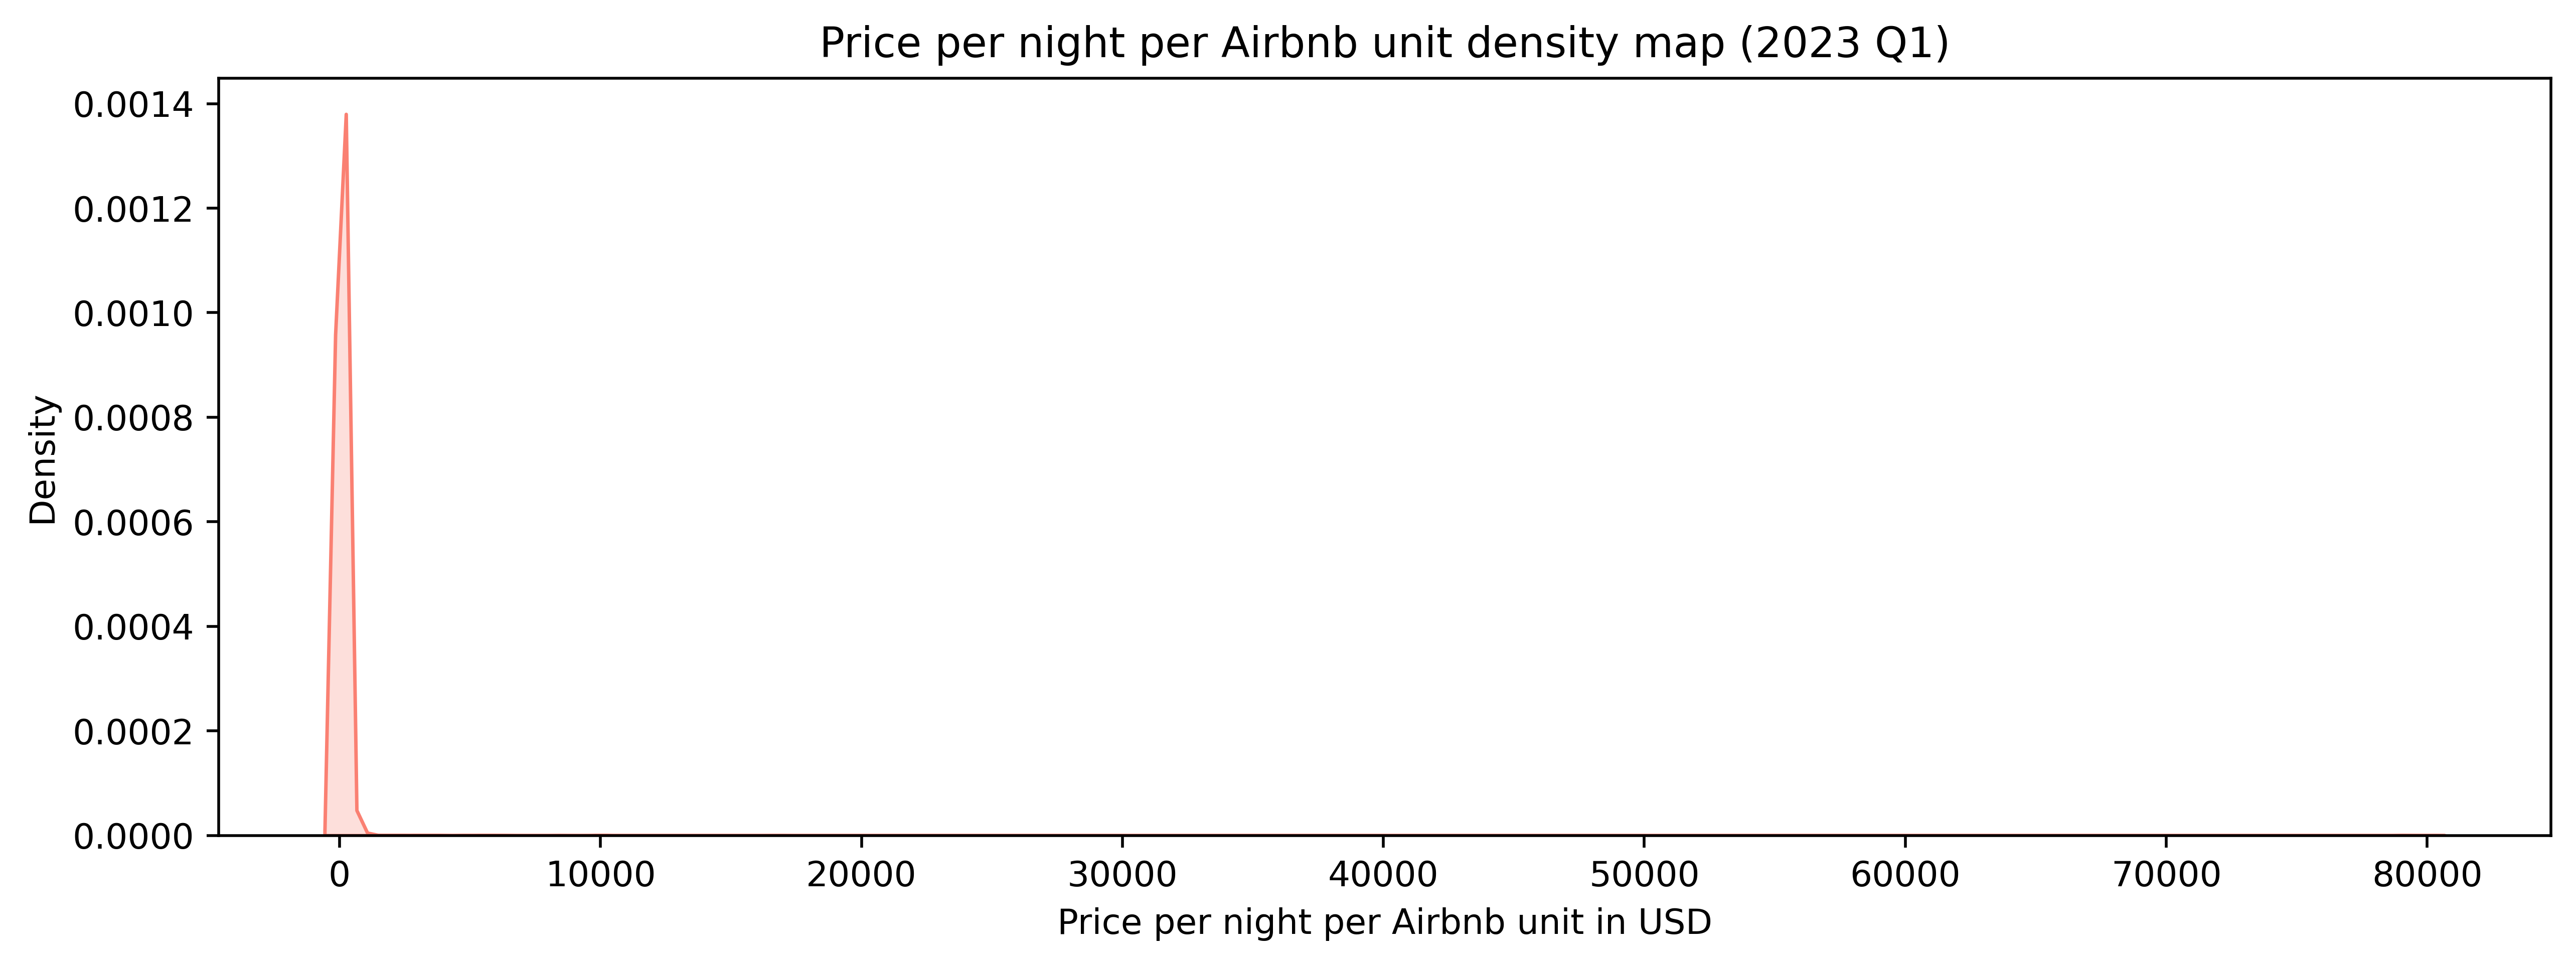

In [21]:
#Print the price distribution
plt.figure(figsize=(12,4),dpi=500)
plt.xlabel('Price per night per Airbnb unit in USD')
plt.title('Price per night per Airbnb unit density map (2023 Q1)')

sns.kdeplot(x=listings_df_ls[0]["price_usd"],color="salmon", shade=True);

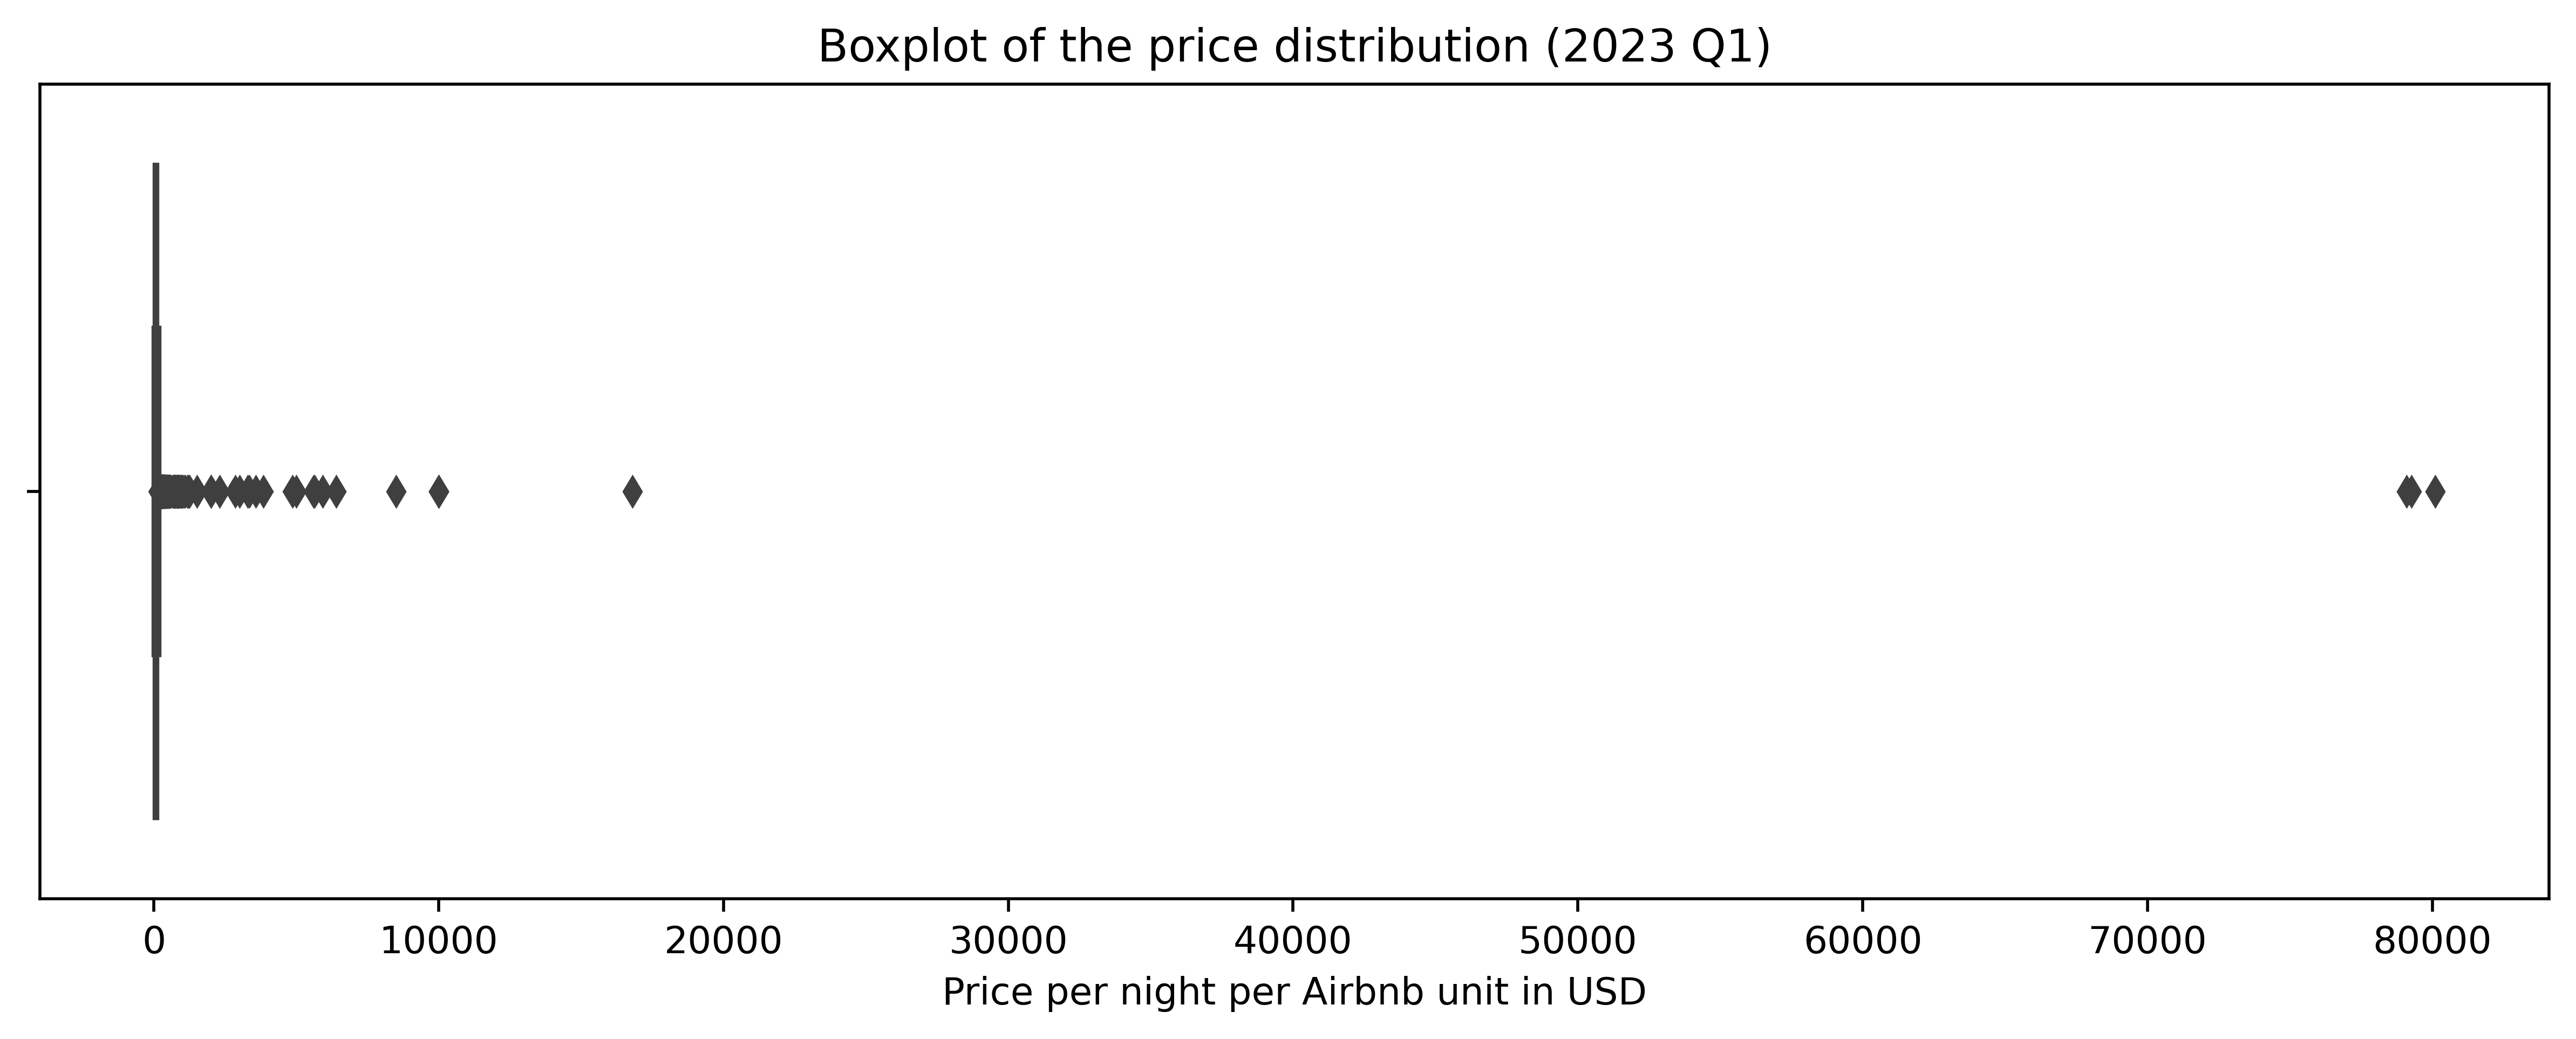

In [22]:
#Print the overall 90-day occupancy rate distribution
plt.figure(figsize=(12,4),dpi=500)

sns.boxplot(data=listings_df_ls[0], x="price_usd")

plt.title('Boxplot of the price distribution (2023 Q1)')
plt.xlabel('Price per night per Airbnb unit in USD');

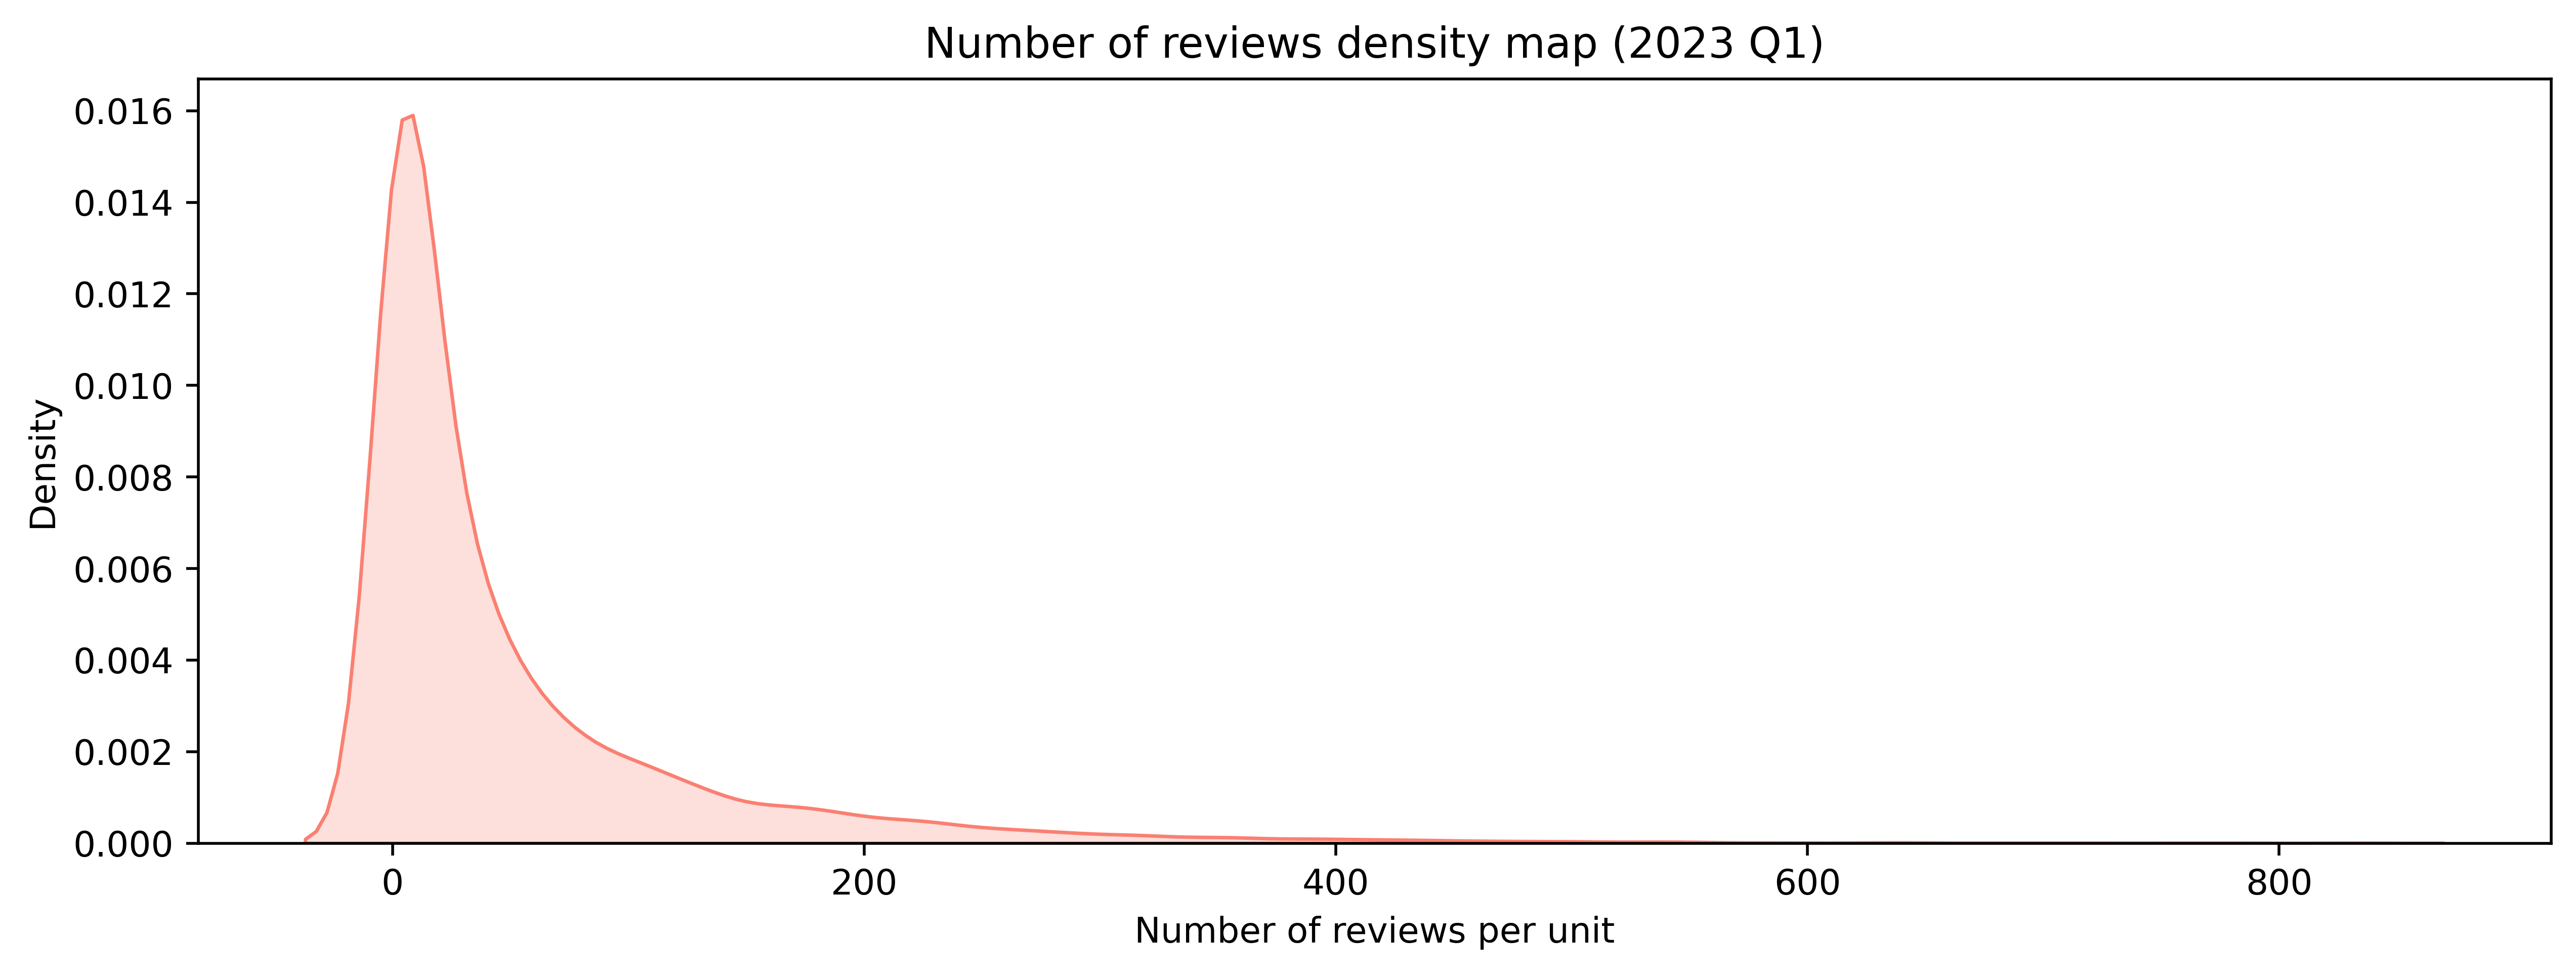

In [23]:
#Print the number of reviews per listing distribution
plt.figure(figsize=(12,4),dpi=500)
plt.xlabel('Number of reviews per unit')
plt.title('Number of reviews density map (2023 Q1)')

sns.kdeplot(x=listings_df_ls[0]["number_of_reviews"],color="salmon", shade=True);

Print the relation of number of reviews with the review score

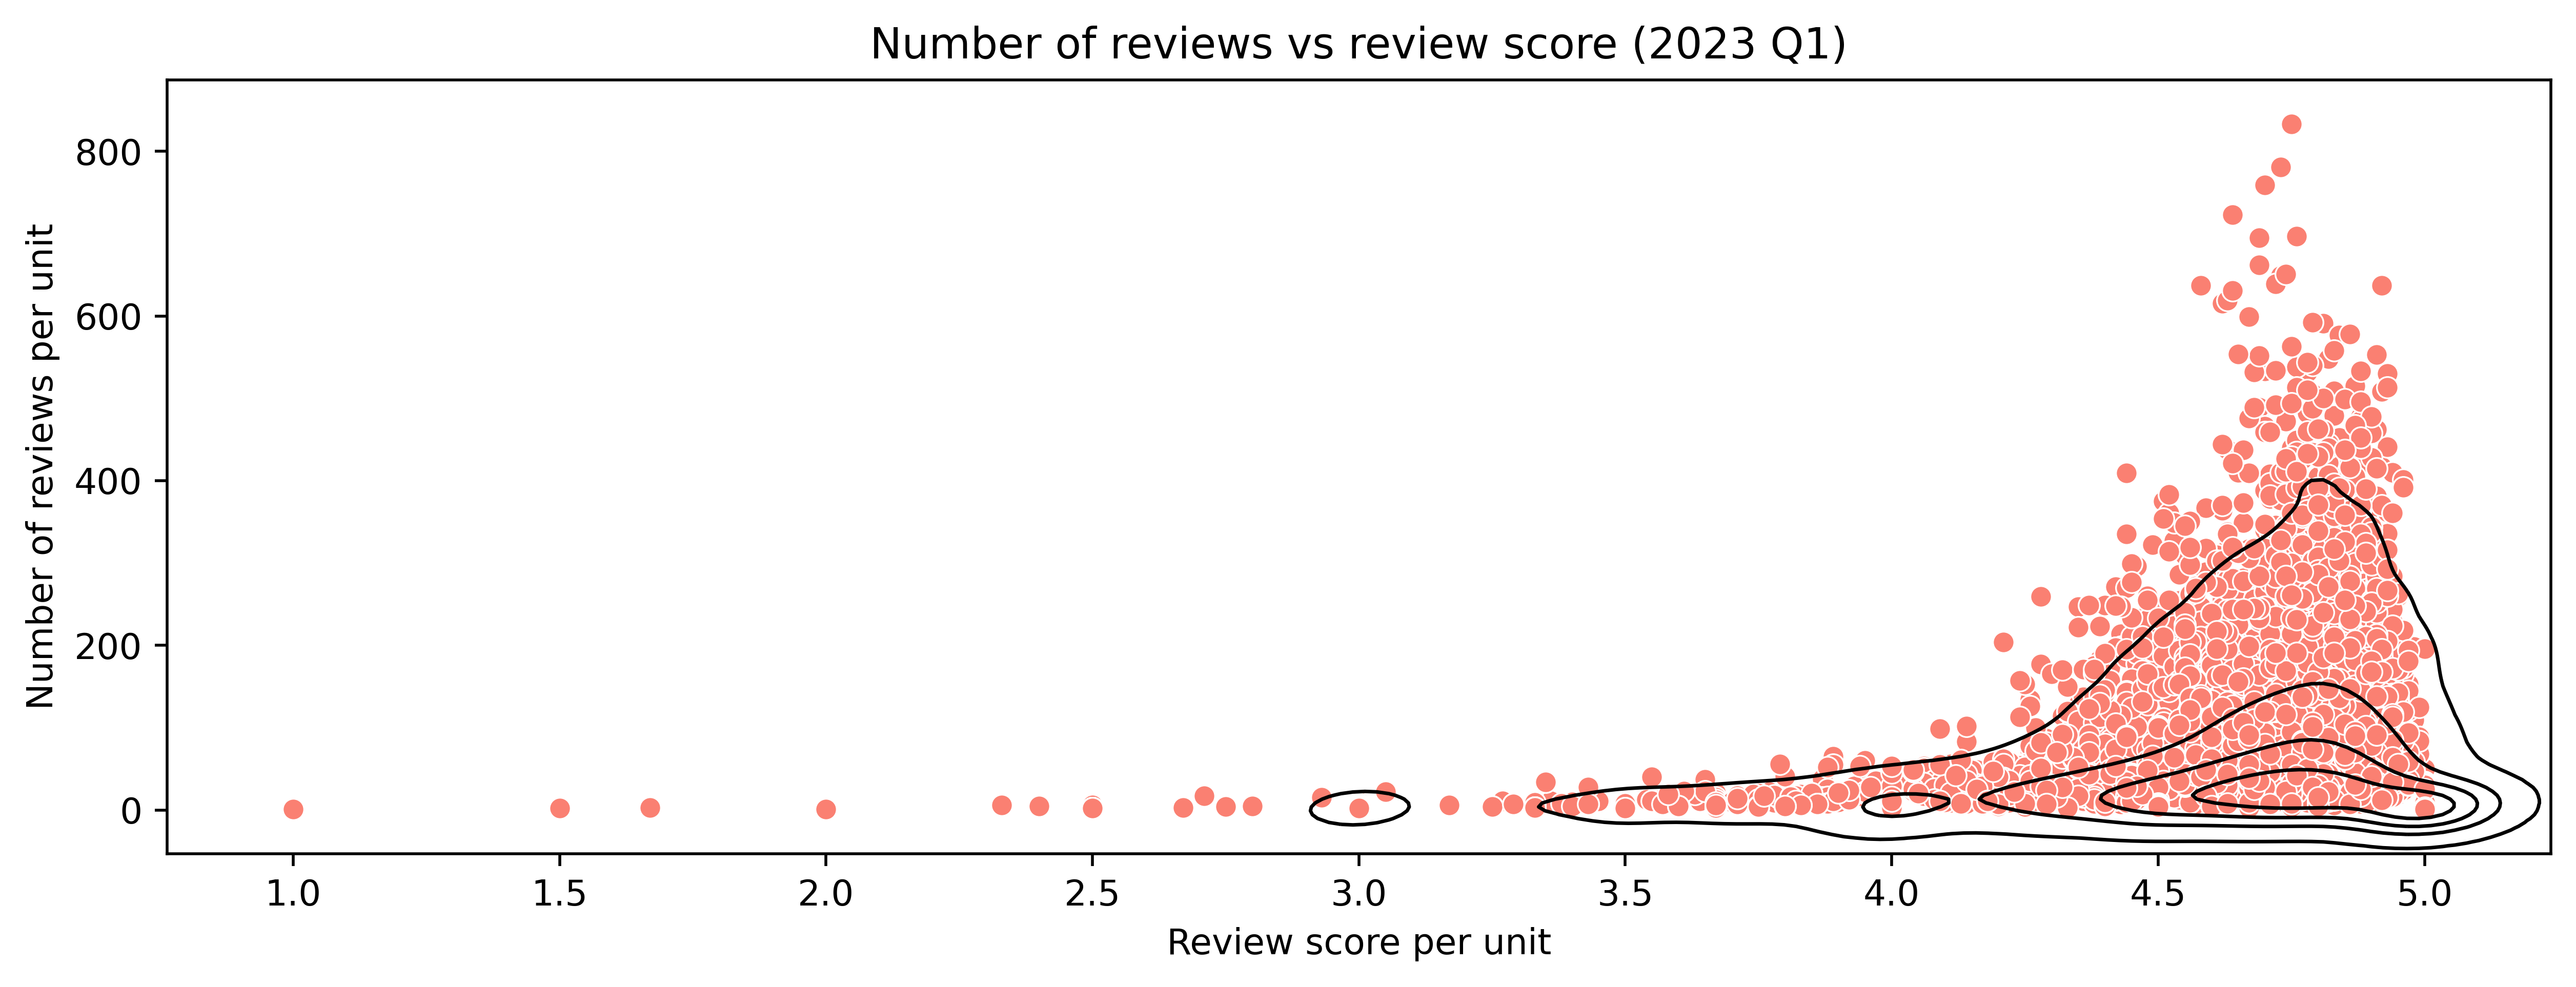

In [24]:
# print scatterplot with kdeplot for number of reviews versus the review score 
plt.figure(figsize=(12,4),dpi=500)
plt.title('Number of reviews vs review score (2023 Q1)')
plt.xlabel('Review score per unit')
plt.ylabel('Number of reviews per unit')

sns.scatterplot(data=listings_df_ls[0],
                x="review_scores_value",
                y="number_of_reviews",
                color="salmon")

sns.kdeplot(data=listings_df_ls[0],
                x="review_scores_value",
                y="number_of_reviews", 
                levels=5, 
                color="black", 
                linewidths=1);

__Observation:__ It seems that there is not a strong relation which supports the thesis that as the number of reviews increases the average of the review score also increases. The highest concentration of highest reviews occurs between 1-200 reviews.
#### <a href="#top">Back to top</a>

<a id='section3_2'></a>
## 3.1. Business-Related Data Analysis

In [25]:
# merge in all dataframes into one
full_data_df = pd.concat(listings_df_ls, axis=0)

<a id='section3_2_1'></a>
### 3.1.1. Analysis of the Number of Listings

Print a bar chart with the number of listings by batch date

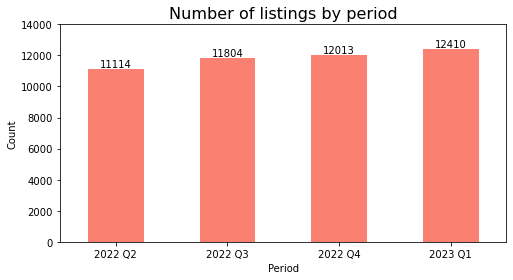

In [26]:
# create the count of listings by period and sort it by period rank
value_counts = full_data_df["period"].value_counts().sort_index()

# Plot the bar chat
plt.figure(figsize=(6,4))

ax = value_counts.plot.bar(figsize=(8,4),color="salmon",legend=False)

for i, value in enumerate(value_counts):
    ax.annotate(f"""{value}""", (i, value), ha='center', va='bottom')
        
ax.set_title("Number of listings by period", fontsize=16)
ax.set_xlabel("Period")
ax.set_ylabel("Count")
plt.ylim((0,14000))
plt.xticks(rotation=0)

plt.show()

__Observation__: It is possible to see a considerable increase in the number of listings because these increases occur in just a 3-month period.

Print a table with the number of listings by batch date broken down by city

In [27]:
# create the count of listings by batch date by period
value_counts = full_data_df.groupby(["period", "neighbourhood_group_cleansed"]).size().unstack().sort_index()
value_counts = value_counts.T
value_counts.reset_index().sort_values("2023 Q1", ascending=False).style.hide_index()

__Observation__: The first thing I noticed here is again how skewed the data is. Secondly almost all of cities kept the increasing trend but some cities like Maia, Espinho, or Arouca show a decrease in the offerings. 

Let's see this in two graphics: one for the biggest cities in terms of oferings and a second for the rest.

In [28]:
# create a separated Dataframe with the results from the table above
value_counts_by_city = value_counts.reset_index().sort_values("2023 Q1", ascending=False)
value_counts_by_city = value_counts_by_city.set_index('neighbourhood_group_cleansed')

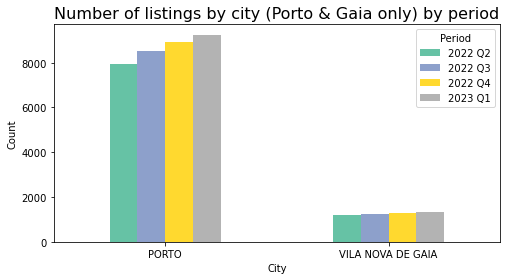

In [29]:
# Plot the 1st bar chat
ax = value_counts_by_city[value_counts_by_city.index.isin(["PORTO","VILA NOVA DE GAIA"])].plot.bar(figsize=(8,4), legend=True, cmap='Set2')

ax.set_title("Number of listings by city (Porto & Gaia only) by period", fontsize=16)
ax.set_xlabel("City")
ax.set_ylabel("Count")

plt.xticks(rotation=0)
plt.legend(title="Period")

plt.show()

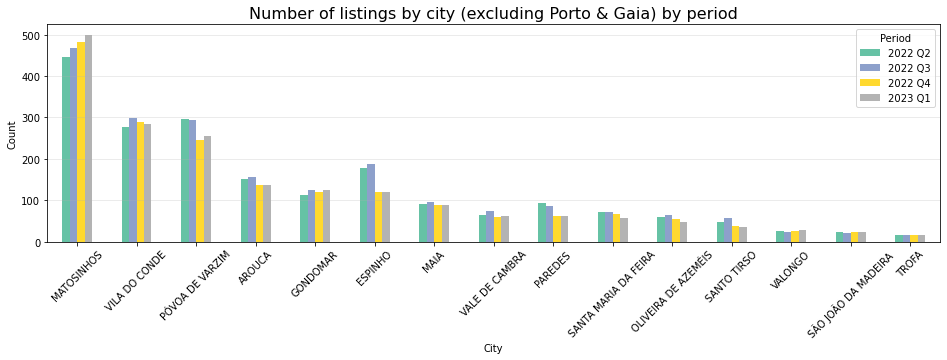

In [30]:
# Plot the 2nd bar chat
ax = value_counts_by_city[~value_counts_by_city.index.isin(["PORTO","VILA NOVA DE GAIA"])].plot.bar(figsize=(16,4), legend=True, cmap='Set2')

ax.set_title("Number of listings by city (excluding Porto & Gaia) by period", fontsize=16)
ax.set_xlabel("City")
ax.set_ylabel("Count")

plt.grid(axis='y', linestyle='-', linewidth=0.5, alpha=0.5)
plt.xticks(rotation=45)
plt.legend(title="Period")

plt.show()

#### <a href="#top">Back to top</a>

<a id='section3_2_2'></a>
### Analysis of the Occupancy Rates

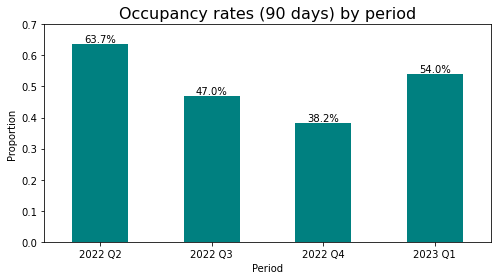

The overall mean of the 90-day occupancy rates between June 2022 and Mars 2023 was 51%.


In [31]:
### get the mean value of the occupancy rates by period
occ_rates_by_batch = full_data_df.groupby("period")["occupancy_rate_90"].mean()

# Plot the bar chat
plt.figure(figsize=(6,4))
ax = occ_rates_by_batch.plot.bar(figsize=(8,4),color="teal",legend=False)

for i, value in enumerate(occ_rates_by_batch):
    ax.annotate(f"""{value*100:.1f}%""", (i, value), ha='center', va='bottom')
        
ax.set_title("Occupancy rates (90 days) by period", fontsize=16)
ax.set_xlabel("Period")
ax.set_ylabel("Proportion")
ax.set_ylim((0,0.7))
plt.xticks(rotation=0)

plt.show();
print("The overall mean of the 90-day occupancy rates between June 2022 and Mars 2023 was {}%.".format(round(full_data_df["occupancy_rate_90"].mean()*100),2))

__Observation__: We can see that in the colder months the occupancy rate tends to decrease, as it is expected since Porto is a touristic city, which is highly impacted by the Tourism seasons of the northern hemisphere. Now let us see if there are noticeable differences between superhosts and non-superhosts.

In [32]:
occ_rates_by_batch_by_host = full_data_df.groupby(["period","host_is_superhost"])["occupancy_rate_90"].mean().unstack()
occ_rates_by_batch_by_host

host_is_superhost         f         t
period                               
2022 Q2            0.623985  0.671584
2022 Q3            0.471338  0.467840
2022 Q4            0.395005  0.354595
2023 Q1            0.523198  0.574575

- __Observation__: This was an interesting finding: One could assume that superhosts would have a bigger occupancy rate, since this is a special distinction in the Airbnb platform, but this data suggests that the numbers are much similar. However, it seems that as the occupancy rates increase, the difference between the two also increases in favor of the superhosts.
- __Suggestion__: One could try to explain this by looking at the price distribution of the occupied and free listings to see if price matters here or by looking into the person correlation to see if this is really a trend. Due to lack of historical data and the scope of this project this will be ignored.

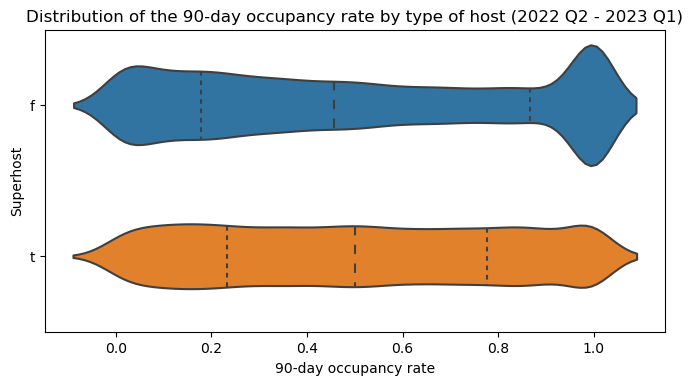

In [33]:
#Print the overall 90-day occupancy rate distribution
plt.figure(figsize=(8,4),dpi=100)

sns.violinplot(data=full_data_df, x="occupancy_rate_90", y="host_is_superhost",inner="quartiles")

plt.title('Distribution of the 90-day occupancy rate by type of host (2022 Q2 - 2023 Q1)')
plt.xlabel('90-day occupancy rate')
plt.ylabel('Superhost');

__Observation__: By looking at the distribution of the overall 90-day occupancy rate it is possible to see that listings from superhosts in general have a higher occupancy rate and that the distribution is very uniform across all amounts of the occupancy rate. The number of listings from non-superhosts overall tends to decrease as the rate increases but there is an interesting peak at 100%, which means that there is a considerable amount of listings from non-superhosts that are usually __sold-out__. 

In [34]:
#Print the mean occupancy rate by city for the 12-month period
full_data_df.groupby("neighbourhood_group_cleansed")["occupancy_rate_90"].mean().sort_values(ascending=False)

neighbourhood_group_cleansed
MATOSINHOS              0.552419
VILA NOVA DE GAIA       0.522174
MAIA                    0.514977
PORTO                   0.514593
SÃO JOÃO DA MADEIRA     0.499638
VALONGO                 0.492169
PÓVOA DE VARZIM         0.471551
ESPINHO                 0.462237
VILA DO CONDE           0.443469
GONDOMAR                0.433726
PAREDES                 0.408646
SANTA MARIA DA FEIRA    0.385779
SANTO TIRSO             0.366355
TROFA                   0.327951
OLIVEIRA DE AZEMÉIS     0.313078
VALE DE CAMBRA          0.303248
AROUCA                  0.264172
Name: occupancy_rate_90, dtype: float64

Print the 90-day occupancy rates by batch date and by city

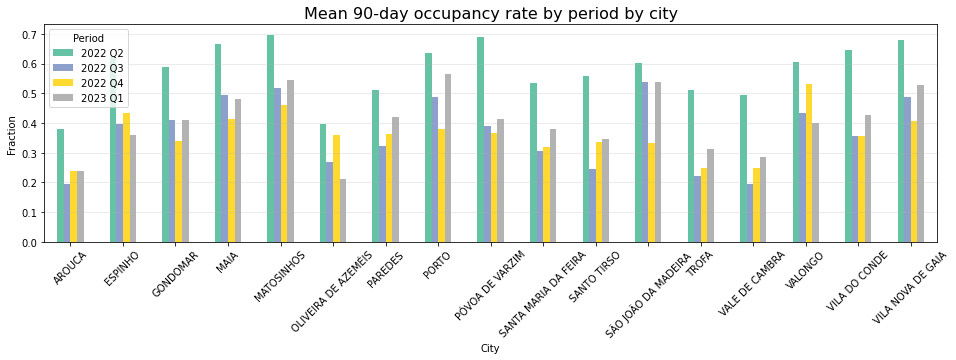

In [35]:
# get the mean value of the occupancy rates by period by city
occ_rates_by_batch_by_city = full_data_df.groupby(["period","neighbourhood_group_cleansed"])["occupancy_rate_90"].mean().unstack()
occ_rates_by_batch_by_city = occ_rates_by_batch_by_city.T

# Plot the bar chat
ax = occ_rates_by_batch_by_city.plot.bar(figsize=(16,4), legend=True, cmap='Set2')

ax.set_title("Mean 90-day occupancy rate by period by city", fontsize=16)
ax.set_xlabel("City")
ax.set_ylabel("Fraction")
plt.grid(axis='y', linestyle='-', linewidth=0.5, alpha=0.5)
plt.xticks(rotation=45)

plt.legend(title="Period")

plt.show()

Print the 90-day occupancy rates by number of reviews over a 12-mothn period

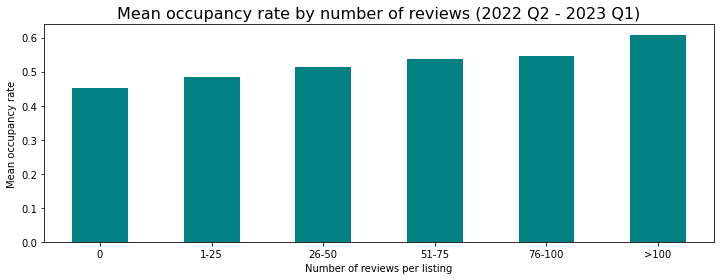

In [36]:
# get the mean value of the occupancy rates by number of reviews
occ_rate_by_reviews = full_data_df.groupby("number_of_reviews")["occupancy_rate_90"].mean()

# transform the nummeric value of number of reviews into categories 
occ_rate_by_reviews = occ_rate_by_reviews.sort_index()
occ_rate_by_reviews = occ_rate_by_reviews.reset_index()

bins = [0, 25, 50, 75, 100, 1000]
labels = ['1-25', '26-50', '51-75', '76-100', '>100']

occ_rate_by_reviews['number_of_reviews'] = pd.cut(occ_rate_by_reviews['number_of_reviews'], bins=bins, labels=labels)
occ_rate_by_reviews['number_of_reviews'] = occ_rate_by_reviews['number_of_reviews'].astype(str).fillna("0")

# get the mean value of the occupancy rates by number of reviews
occ_rate_by_reviews = occ_rate_by_reviews.groupby("number_of_reviews")["occupancy_rate_90"].mean().sort_index()

# Plot the bar chat
ax = occ_rate_by_reviews.plot.bar(figsize=(12,4),color="teal",legend=False)
        
ax.set_title("Mean occupancy rate by number of reviews (2022 Q2 - 2023 Q1)", fontsize=16)
ax.set_xlabel("Number of reviews per listing")
ax.set_ylabel("Mean occupancy rate")
plt.xticks(rotation=0)

plt.show();

#### <a href="#top">Back to top</a>

<a id='section3_2_3'></a>
### Analysis of the Prices

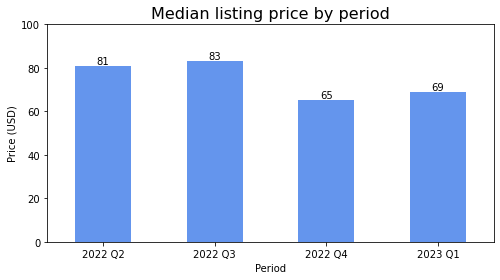

The overall median of the 90-day unit price between June 2022 and Mars 2023 was $75.0.


In [37]:
# get the mean value of the prices by period
prices_by_batch = full_data_df.groupby("period")["price_usd"].median()

# Plot the bar chat
ax = prices_by_batch.plot.bar(figsize=(8,4),color="#6495ED",legend=False)

for i, value in enumerate(prices_by_batch):
    ax.annotate(f"""{value:.0f}""", (i, value), ha='center', va='bottom')
        
ax.set_title("Median listing price by period", fontsize=16)
ax.set_xlabel("Period")
ax.set_ylabel("Price (USD)")

plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.show();
print("The overall median of the 90-day unit price between June 2022 and Mars 2023 was ${}.".format(full_data_df["price_usd"].median()))

__Observations__: 
- The prices seem to vary between with the time of the year but without more historical data is impossible to determine if there is a trend here. 
- Price can also be related with other factors like location, number of bedrooms or if it is a superhost.

In [38]:
#Print the media unit price rate by caty for the 12-month period
full_data_df.groupby("neighbourhood_group_cleansed")["price_usd"].median().sort_values(ascending=False)

neighbourhood_group_cleansed
TROFA                   120.0
VALE DE CAMBRA          110.5
GONDOMAR                100.0
AROUCA                   99.0
SANTO TIRSO              92.5
PAREDES                  92.0
VILA DO CONDE            80.0
PÓVOA DE VARZIM          80.0
ESPINHO                  75.0
PORTO                    74.0
SANTA MARIA DA FEIRA     70.0
VILA NOVA DE GAIA        70.0
VALONGO                  69.0
MATOSINHOS               68.0
MAIA                     65.0
OLIVEIRA DE AZEMÉIS      60.0
SÃO JOÃO DA MADEIRA      49.0
Name: price_usd, dtype: float64

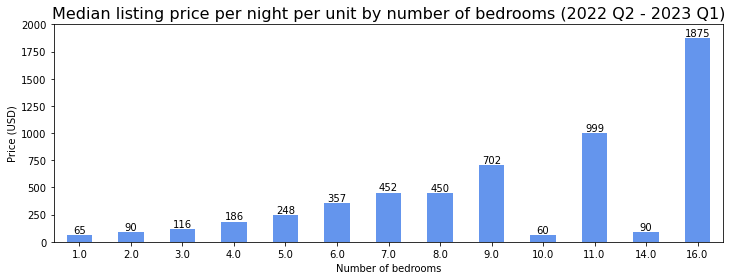

In [39]:
# Get the median value of the prices by number of bedrooms
prices_by_bedrooms = full_data_df.groupby("bedrooms")["price_usd"].median()

# Plot the bar chat
ax = prices_by_bedrooms.plot.bar(figsize=(12,4),color="#6495ED",legend=False)

for i, value in enumerate(prices_by_bedrooms):
    ax.annotate(f"""{value:.0f}""", (i, value), ha='center', va='bottom')
        
ax.set_title("Median listing price per night per unit by number of bedrooms (2022 Q2 - 2023 Q1)", fontsize=16)
ax.set_xlabel("Number of bedrooms")
ax.set_ylabel("Price (USD)")
plt.ylim(0, 2000)
plt.xticks(rotation=0)

plt.show();

In [40]:
# Print number of units with 10 bedrooms by batch date
full_data_df[full_data_df["bedrooms"] == 10].groupby(["bedrooms", "calendar_last_scraped"]).size()

bedrooms  calendar_last_scraped
10.0      2022-06-01               5
          2022-09-01               5
          2022-12-01               4
          2023-03-01               4
dtype: int64

__Observation:__ As expected the median value unit price tends to increase with the number of bedrooms. There are two values that do not follow this trend but this is highly influenced due to the small amount of listings for these categories.

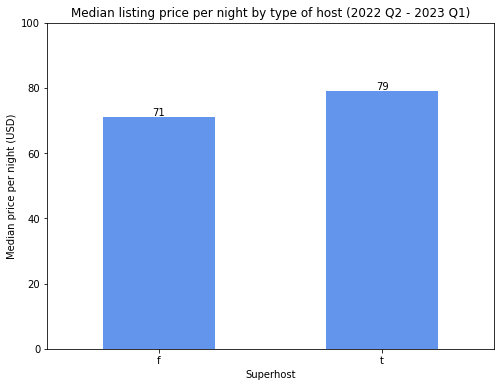

In [41]:
# Get the median value of the prices by type of host
prices_by_bedrooms = full_data_df.groupby("host_is_superhost")["price_usd"].median()

# Plot the bar chat
ax = prices_by_bedrooms.plot.bar(figsize=(8,6),color="#6495ED",legend=False)

for i, value in enumerate(prices_by_bedrooms):
    ax.annotate(f"""{value:.0f}""", (i, value), ha='center', va='bottom')
        
ax.set_title("Median listing price per night by type of host (2022 Q2 - 2023 Q1)", fontsize=12)
ax.set_xlabel("Superhost")
ax.set_ylabel("Median price per night (USD)")
ax.set_ylim([0,100])
plt.xticks(rotation=0)

plt.show();

__Observation__: Superhosts seem to have a slightly bigger median price per unit.

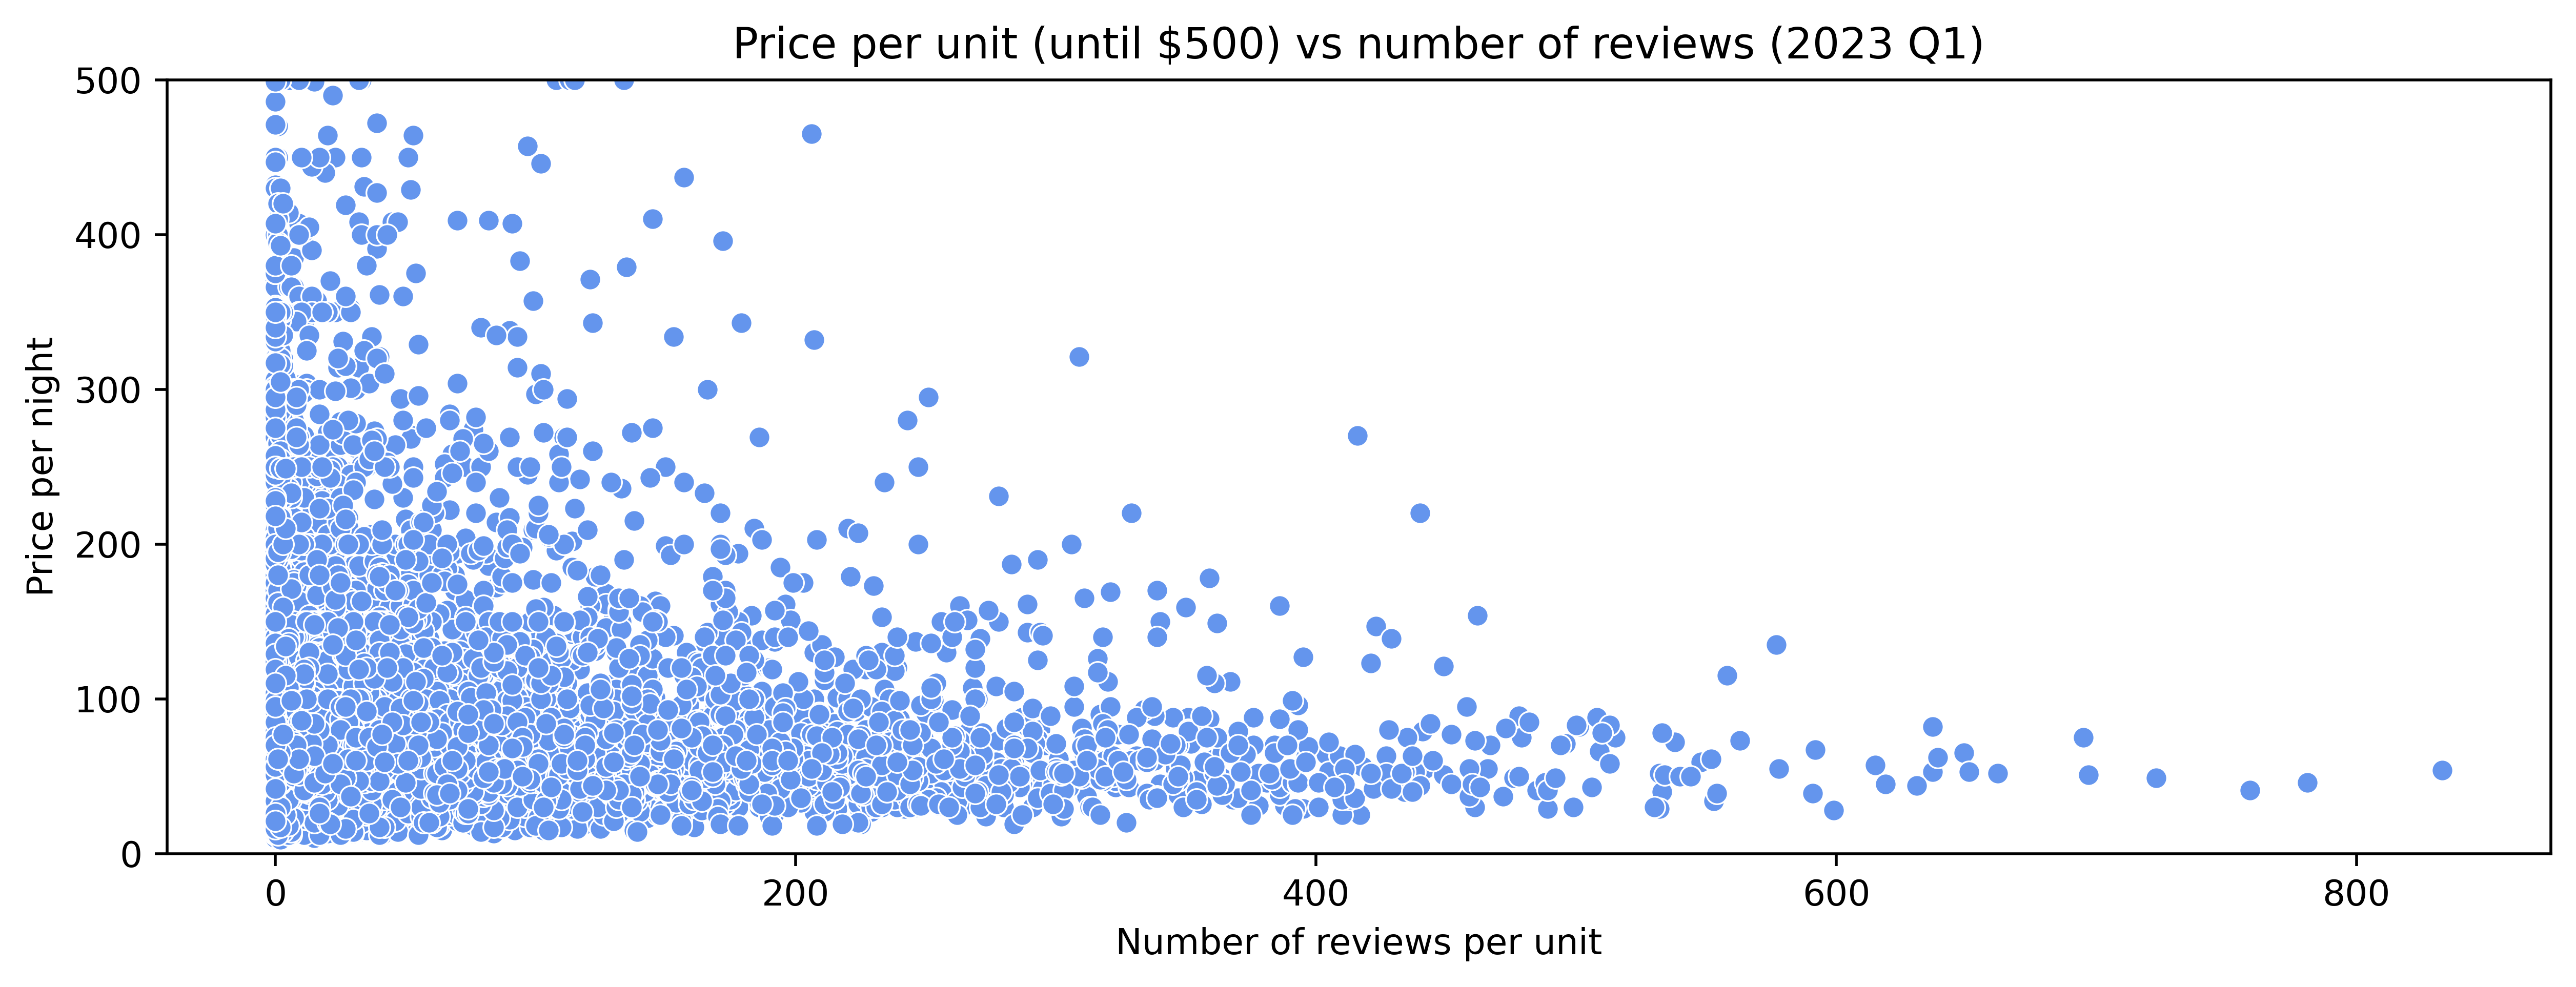

In [42]:
# print scatterplot for the price per unit vs number of reviews
plt.figure(figsize=(12,4),dpi=500)
plt.title('Price per unit (until $500) vs number of reviews (2023 Q1)')
plt.xlabel('Number of reviews per unit')
plt.ylabel('Price per night')
plt.ylim(0,500)

sns.scatterplot(data=listings_df_ls[0],
                x="number_of_reviews",
                y="price_usd",
                color="#6495ED");

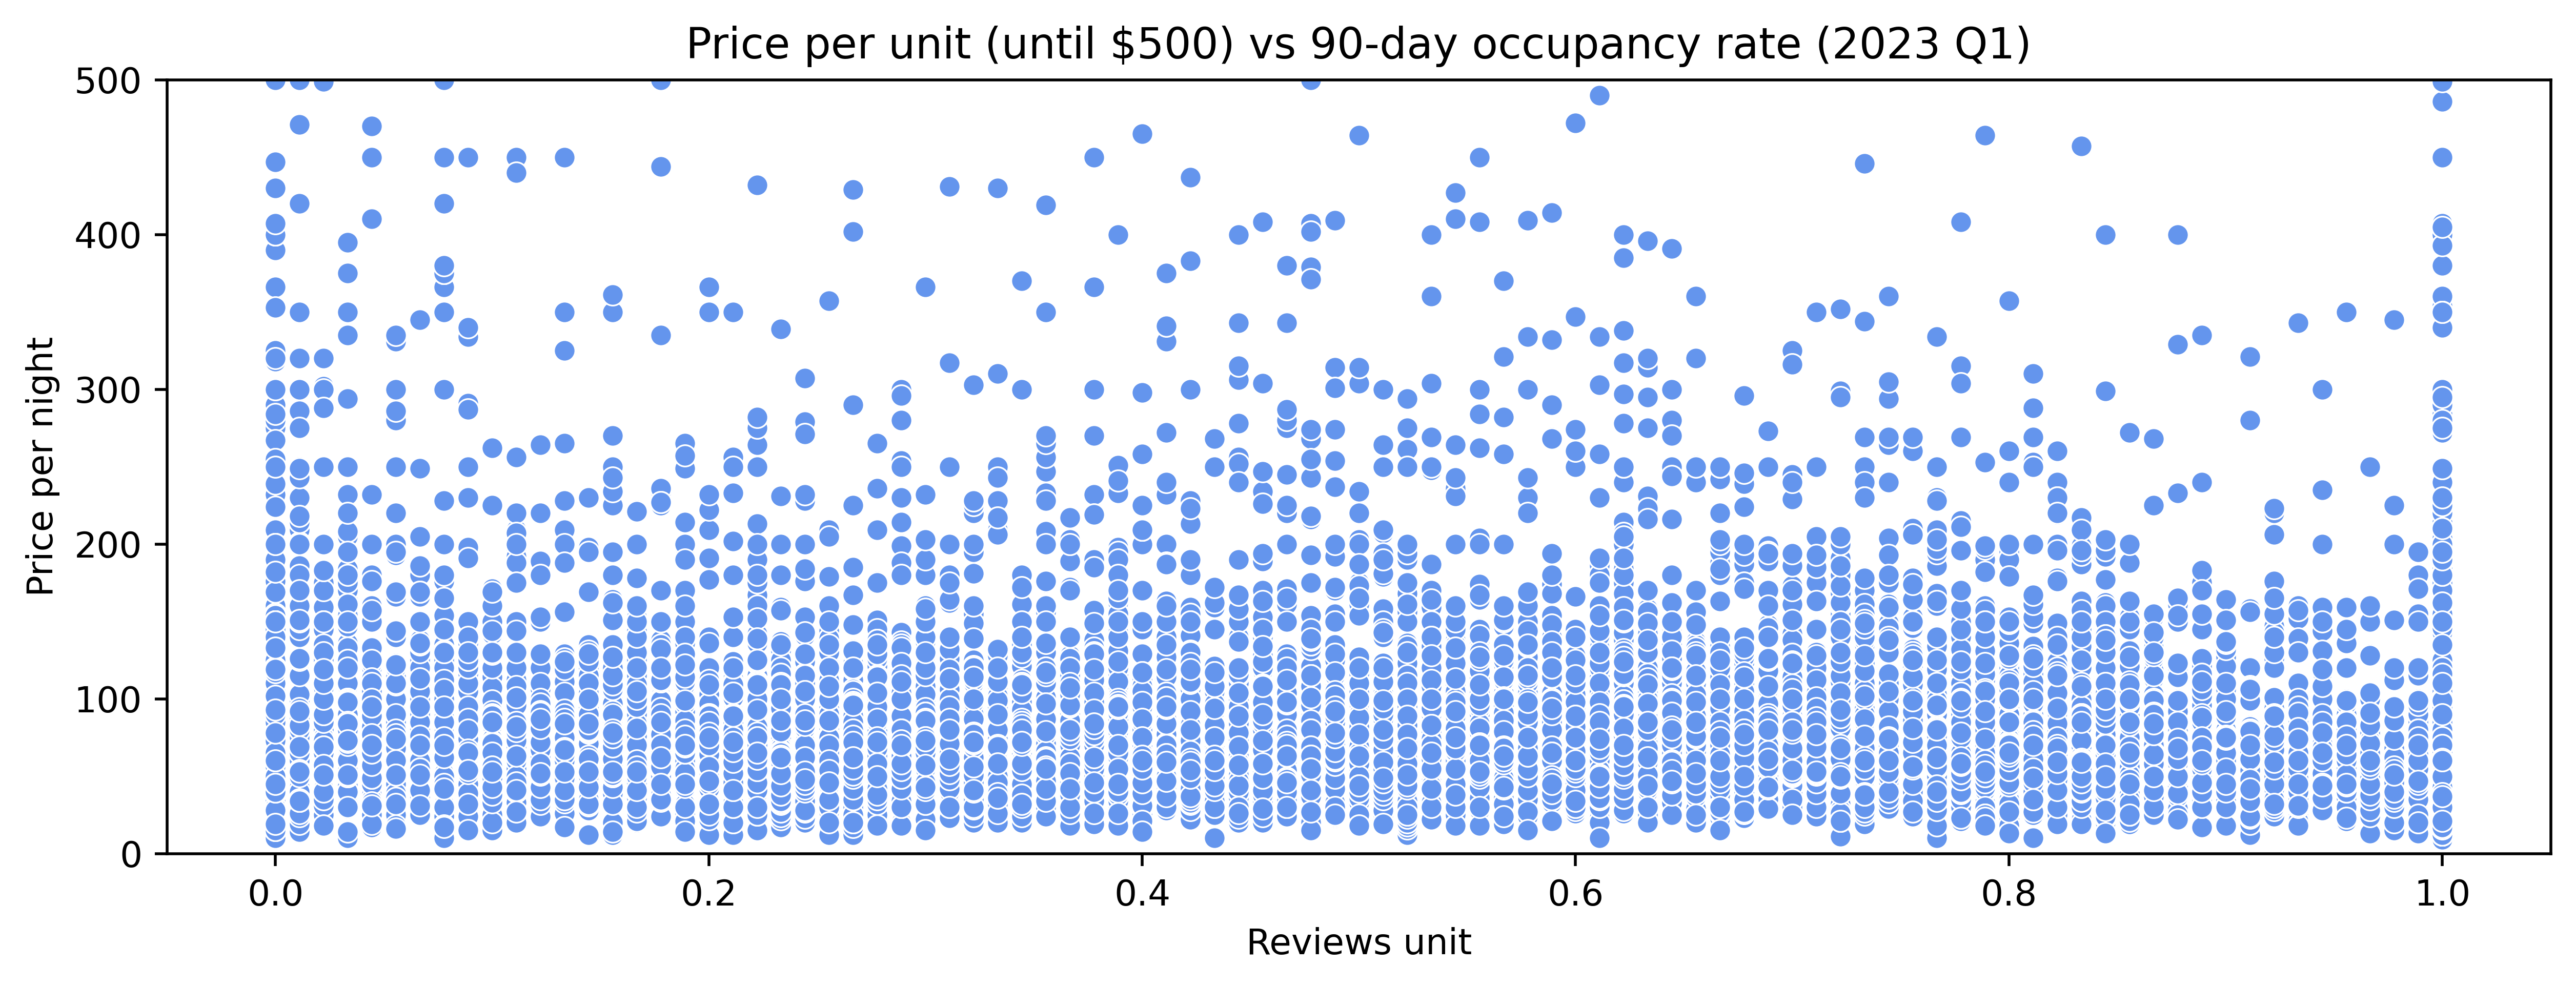

In [43]:
# print scatterplot for the price per unit vs 90-day occupancy rate
plt.figure(figsize=(12,4),dpi=500)
plt.title('Price per unit (until $500) vs 90-day occupancy rate (2023 Q1)')
plt.xlabel('Reviews unit')
plt.ylabel('Price per night')
plt.ylim(0,500)

sns.scatterplot(data=listings_df_ls[0],
                x="occupancy_rate_90",
                y="price_usd",
                color="#6495ED");

__Observation:__ Looking at the two scatterplots above it is possible to see that neither the 90-day occupancy rate nor the number of reviews per unit seem to have a correlation with the price per unit.

#### <a href="#top">Back to top</a>

<a id='section4'></a>
# 4. Modeling

In this section I tried to create a machine learning model that is able to predict the price per night per unit based on the listing's dataset available for the Q1 2023. I thought it was not relevant to include the overall data since I am not using any historical data for this prediction.

It should be mentioned that this model can only predict based on the features available in the dataset and there could be more aspects which may be important and are not captured here, like mentioned in the introduction of this project. 
With this in mind, these are the features which were used for __training__:
- neighbourhood_cleansed
- host_is_superhost
- property_type
- room_type
- accommodates
- bathrooms_text
- bedrooms
- beds
- amenities

The __target__ variable was the:
- price_usd

Features left out:
- Features like the __90-day occupancy rate__ or __number or reviews__ were purposely left out because they do not have any strong correlation with the price and if we were looking at a new listing these features would be 0, so it could be a bad idea to compare it with others, although one could argue that this could be used as a pricing strategy. However this goes beyond the scope. 

- Other features that were left out were __latitude__ and __longitude__. Although it is true that geospacial that can be very important in this scenario, we already have the feature neighbourhood_cleansed which includes 150 unique values and should be sufficient.

#### <a href="#top">Back to top</a>

<a id='section4_1'></a>
## 4.1 Feature Engineering

In this section I transformed the text categorical features into numeric features so they can be used for training the algorithm and also created new features based of the columns bathroom_text and amenities.

In [44]:
# read in the Q1 2023 dataset
target_df = listings_df_ls[0].copy()

<a id='section4_1_1'></a>
### Feature: neighbourhood_cleansed

In [45]:
# Use dummy encoding to transform the categorical column into binary columns for each unique value
target_df = target_df.join(pd.get_dummies(target_df["neighbourhood_cleansed"]))
print(target_df.columns)

Index(['id', 'host_id', 'host_is_superhost', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates',
       ...
       'Vila Nova do Campo', 'Vila de Cucujães', 'Vila do Conde',
       'Vilar de Andorinho', 'Vilar de Pinheiro', 'Vilar e Mosteiró', 'Várzea',
       'Água Longa', 'Águas Santas', 'Árvore'],
      dtype='object', length=173)


#### <a href="#top">Back to top</a>

<a id='section4_1_2'></a>
### Feature: host_is_superhost

In [46]:
#transform the value in host_is_superhost for better readability
target_df["host_is_superhost"] = target_df["host_is_superhost"].map({"f": "superhost_false", "t":"superhost_true"})

In [47]:
# Use dummy encoding to transform the categorical column into binary columns for each unique value
target_df = target_df.join(pd.get_dummies(target_df["host_is_superhost"]))
print(target_df.columns)

Index(['id', 'host_id', 'host_is_superhost', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates',
       ...
       'Vila do Conde', 'Vilar de Andorinho', 'Vilar de Pinheiro',
       'Vilar e Mosteiró', 'Várzea', 'Água Longa', 'Águas Santas', 'Árvore',
       'superhost_false', 'superhost_true'],
      dtype='object', length=175)


#### <a href="#top">Back to top</a>

<a id='section4_1_3'></a>
### Feature: property_type

In [48]:
# Use dummy encoding to transform the categorical column into binary columns for each unique value
target_df = target_df.join(pd.get_dummies(target_df["property_type"]))
print(target_df.columns)

Index(['id', 'host_id', 'host_is_superhost', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates',
       ...
       'Shared room in guest suite', 'Shared room in guesthouse',
       'Shared room in home', 'Shared room in hostel',
       'Shared room in rental unit', 'Shipping container', 'Tiny home', 'Tipi',
       'Treehouse', 'Windmill'],
      dtype='object', length=246)


#### <a href="#top">Back to top</a>

### Feature: room_type

In [49]:
#transform the value in room_type to avoid overlap
target_df["room_type"] = target_df["room_type"].map({"Shared room": "Shared room type",
                                                     "Private room":"Private room type",
                                                     "Entire home/apt":"Entire home/apt type",
                                                     "Hotel room":"Hotel room type"})

In [50]:
# Use dummy encoding to transform the categorical column into binary columns for each unique value
target_df = target_df.join(pd.get_dummies(target_df["room_type"]))
print(target_df.columns)

Index(['id', 'host_id', 'host_is_superhost', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates',
       ...
       'Shared room in rental unit', 'Shipping container', 'Tiny home', 'Tipi',
       'Treehouse', 'Windmill', 'Entire home/apt type', 'Hotel room type',
       'Private room type', 'Shared room type'],
      dtype='object', length=250)


#### <a href="#top">Back to top</a>

<a id='section4_1_4'></a>
### Feature: bathrooms_text
From the bathroom text I created two new columns using Regex pattern matching: _bathrooms_ and _bathroom_shared_.

In [51]:
target_df["bathrooms_text"].unique()

array(['1.5 shared baths', '2 shared baths', '1 private bath',
       '3 shared baths', '1 bath', '2 baths', '1 shared bath', '5 baths',
       '3 baths', '6 baths', '1.5 baths', '7 baths', '4 baths',
       '3.5 baths', '0 baths', '5.5 baths', '2.5 baths', '8 baths',
       '11 baths', '9 baths', '3.5 shared baths', '4.5 baths', nan,
       '0 shared baths', '2.5 shared baths', 'Shared half-bath',
       '6.5 baths', 'Half-bath', '4 shared baths', '8.5 baths',
       '7.5 shared baths', '5 shared baths', '6 shared baths',
       '4.5 shared baths', '7.5 baths', '10 baths', 'Private half-bath',
       '16 baths', '10.5 baths'], dtype=object)

There are some _missing values_ that need to be treated first. Here I used the information available in _room_type_ and _bedrooms_ and added the mode found for the same categories in the dataset.

In [52]:
# get the mode of bathrooms_text for the specific categories room_type and bedrooms and fill in the missing values
mode_per_group = target_df.groupby(["room_type","bedrooms"])["bathrooms_text"].transform(lambda x: x.mode()[0])
target_df["bathrooms_text"] = target_df["bathrooms_text"].fillna(mode_per_group)

print("Number of missing data in bathrooms_text: {}".format(len(target_df[target_df["bathrooms_text"].isna()])))

Number of missing data in bathrooms_text: 0


In [53]:
# Extract the number of bathrooms (if no number is found then set 0.5)
target_df["bathrooms"] = target_df["bathrooms_text"].str.extract(r'(\d?.?\d)').fillna(0.5).astype(float)

In [54]:
# Extract the information if baths are shared (if the text "hared" is not found then set 0)
target_df["bathrooms_shared"] = np.where(target_df['bathrooms_text'].str.contains('hared', regex=False), 1, 0)

In [55]:
target_df[["bathrooms_text","bathrooms","bathrooms_shared"]].head(10)

bathrooms_text  bathrooms  bathrooms_shared
0  1.5 shared baths        1.5                 1
1  1.5 shared baths        1.5                 1
2  1.5 shared baths        1.5                 1
3    2 shared baths        2.0                 1
4    2 shared baths        2.0                 1
5  1.5 shared baths        1.5                 1
6    2 shared baths        2.0                 1
7    1 private bath        1.0                 0
8    3 shared baths        3.0                 1
9            1 bath        1.0                 0

#### <a href="#top">Back to top</a>

<a id='section4_1_5'></a>
### Feature: amenities
This feature contains a list of strings and therefore needs to be converted into dummy variables. Please read through this section, to see which approach I have chosen in order to select a subset of the amenities.

In [56]:
# Transform the amenities column into dummy variables of 1 and 0

# Create an instance of MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the amenities column
dummy_df = pd.DataFrame(mlb.fit_transform(target_df['amenities'].apply(lambda x: list(x.split(",")))), columns=mlb.classes_)

In [57]:
print(f"""Number of distinct amenities: {len(mlb.classes_)}""")

Number of distinct amenities: 2173


__Observation__: to create dummy variables from the amenities I used the multi-label binarizer algorithm from scikit-learn. However, I quickly noticed that the number of columns would be __too high__ to be used for training, as it would make the problem __too complex__, so I investigated the distribution of the frequency of the amenities to see if I could reduce the number of amenities. 

In [58]:
# get the frequency per amenity
amenities_count = pd.DataFrame(target_df['amenities'])['amenities'].apply(lambda x: x.split(",")).explode('amenities').value_counts()

In [59]:
# print the top 10 most frequent amenities in relation to the total number of Airbnb units
(amenities_count/len(target_df)).head(10)

 "Kitchen"                  0.903062
 "Hair dryer"               0.862127
 "Fire extinguisher"        0.807413
 "Hangers"                  0.800645
 "First aid kit"            0.790330
 "Wifi"                     0.788880
 "Essentials"               0.752377
 "Dishes and silverware"    0.747542
 "Iron"                     0.717969
 "Cooking basics"           0.689122
Name: amenities, dtype: float64

In [60]:
# print the top 10 less frequent amenities in relation to the total number of Airbnb units
(amenities_count/len(target_df)).tail(10)

 "Bosch  single oven"                         0.000081
 "IKEA  stainless steel oven"                 0.000081
 "KNG sound system with Bluetooth and aux"    0.000081
 "26\" HDTV with Amazon Prime Video           0.000081
["Fast wifi \u2013 213 Mbps"                  0.000081
 "Fast wifi \u2013 466 Mbps"                  0.000081
 "Fast wifi \u2013 517 Mbps"                  0.000081
 "IKEA oven"                                  0.000081
 "Zanussi stainless steel stove"              0.000081
 "Kunft electric stove"                       0.000081
Name: amenities, dtype: float64

In [61]:
# print out the summary statistics and the distribution of the frequency of amenities
amenities_count.describe(percentiles=[0,0.25,0.05,0.75,0.8,0.85,0.9,0.95,0.99])

count     2173.000000
mean       171.509894
std        924.940504
min          1.000000
0%           1.000000
5%           1.000000
25%          1.000000
50%          2.000000
75%          7.000000
80%         14.000000
85%         28.000000
90%         76.000000
95%        535.800000
99%       4844.840000
max      11207.000000
Name: amenities, dtype: float64

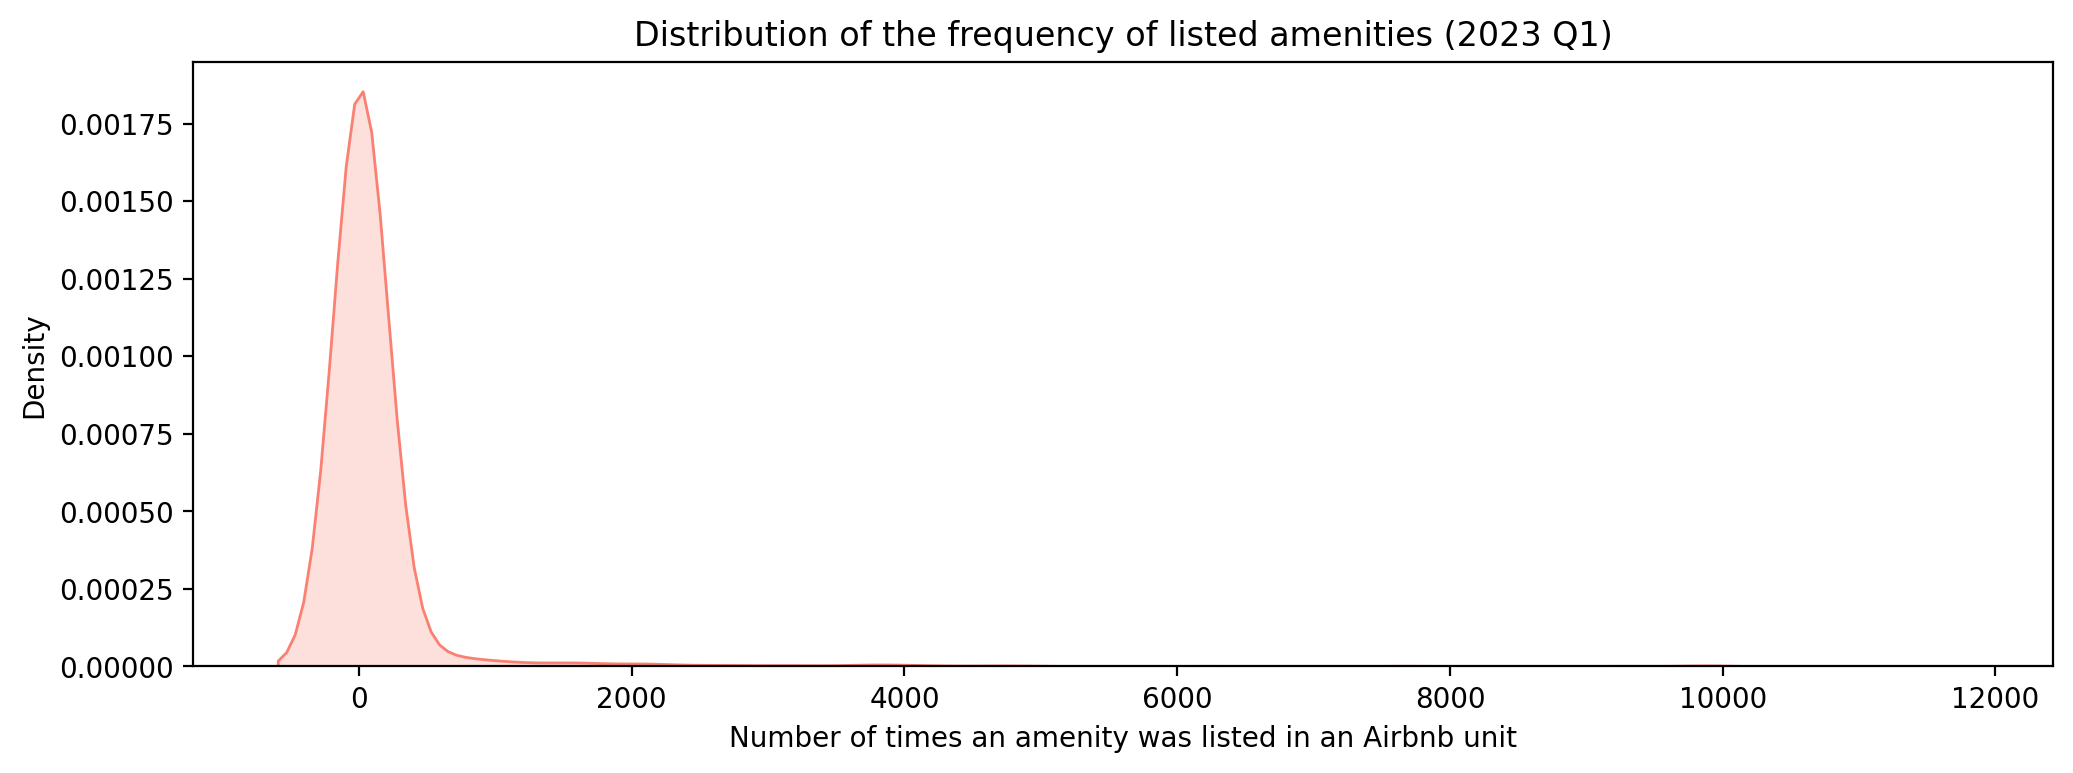

In [62]:
#Print the distribution of the frequency of amenities
plt.figure(figsize=(12,4),dpi=200)
plt.xlabel('Number of times an amenity was listed in an Airbnb unit')
plt.title('Distribution of the frequency of listed amenities (2023 Q1)')

sns.kdeplot(x=amenities_count,color="salmon", shade=True);

__Observation__: By looking at the distribution of the data and the rate of appearence of the top amenities it is possible to identify some challenges:
- I wanted to find a list of interesting amenities, so I wanted to discard the most common ones as they probably will not have any predictive power. 
- I also did not want to use very uncommon amenities as they can potentially bias the prediction and make the model too complex.


With this in mind and looking at the distribution I could not find a feasible approach on how to define a range of interesting frequencies just based on the summary statistics. Therefore, I decided to calculate the __pearson correlation__ each amenity had in relation to the price and based on that hopefully make a better explainable decision.

In [63]:
# add the price column to the amenities dataframe resulted from the MultiLabelBinarizer
dummy_df["price_usd"] = target_df["price_usd"]
dummy_df.head(3)

" 2 glass-ceramic hobs/plates induction stove"  \
0                                                0   
1                                                0   
2                                                0   

    " built-in refrigerator with small freezer compartment refrigerator"  \
0                                                                      0   
1                                                                      0   
2                                                                      0   

    "- refrigerator"   ". body soap"   ". oven"   ". shampoo"   ". stove"  \
0                  0               0          0             0           0   
1                  0               0          0             0           0   
2                  0               0          0             0           0   

    "100\" HDTV with premium cable   "100\" HDTV with standard cable"]  \
0                                0                                   0   
1                                0                                   0   
2                                0                                   0   

    "107\" HDTV with Chromecast   "10\" HDTV with Netflix  \
0                             0                         0   
1                             0                         0   
2                             0                         0   

    "110\" TV with standard cable   "13\" TV with standard cable"   "14\" TV"  \
0                               0                               0           0   
1                               0                               0           0   
2                               0                               0           0   

    "15\" HDTV with Netflix"   "16\" HDTV with standard cable"  \
0                          0                                 0   
1                          0                                 0   
2                          0                                 0   

    "17\" HDTV with standard cable"   "18\" TV with standard cable"  \
0                                 0                               0   
1                                 0                               0   
2                                 0                               0   

    "200\" HDTV with standard cable"   "20\" HDTV with Netflix"  \
0                                  0                          0   
1                                  0                          0   
2                                  0                          0   

    "20\" HDTV with standard cable   "20\" TV with Netflix  \
0                                0                       0   
1                                0                       0   
2                                0                       0   

    "20\" TV with standard cable"   "21\" HDTV with premium cable"  \
0                               0                                0   
1                               0                                0   
2                               0                                0   

    "21\" HDTV with standard cable"   "21\" HDTV"  \
0                                 0             0   
1                                 0             0   
2                                 0             0   

    "22\" HDTV with premium cable"   "22\" HDTV with standard cable"  \
0                                0                                 0   
1                                0                                 0   
2                                0                                 0   

    "22\" HDTV with standard cable"]   "22\" HDTV"  \
0                                  0             0   
1                                  0             0   
2                                  0             0   

    "22\" TV with standard cable"   "22\" TV"   "23\" TV with standard cable"  \
0                               0           0                               0   
1                               0           0                               

In [64]:
#calculate the correlation between each amenity and the price
amenity_corr = dummy_df.corr()['price_usd']

#remove the price from the correlation analysis as it is 1
amenity_corr = amenity_corr.reset_index()
amenity_corr = amenity_corr[amenity_corr["index"] != "price_usd"]

amenity_corr.head()

index  \
0                         " 2 glass-ceramic hobs/plates induction stove"   
1   " built-in refrigerator with small freezer compartment refrigerator"   
2                                                       "- refrigerator"   
3                                                          ". body soap"   
4                                                               ". oven"   

   price_usd  
0  -0.000436  
1  -0.000436  
2  -0.000031  
3  -0.000501  
4  -0.000478

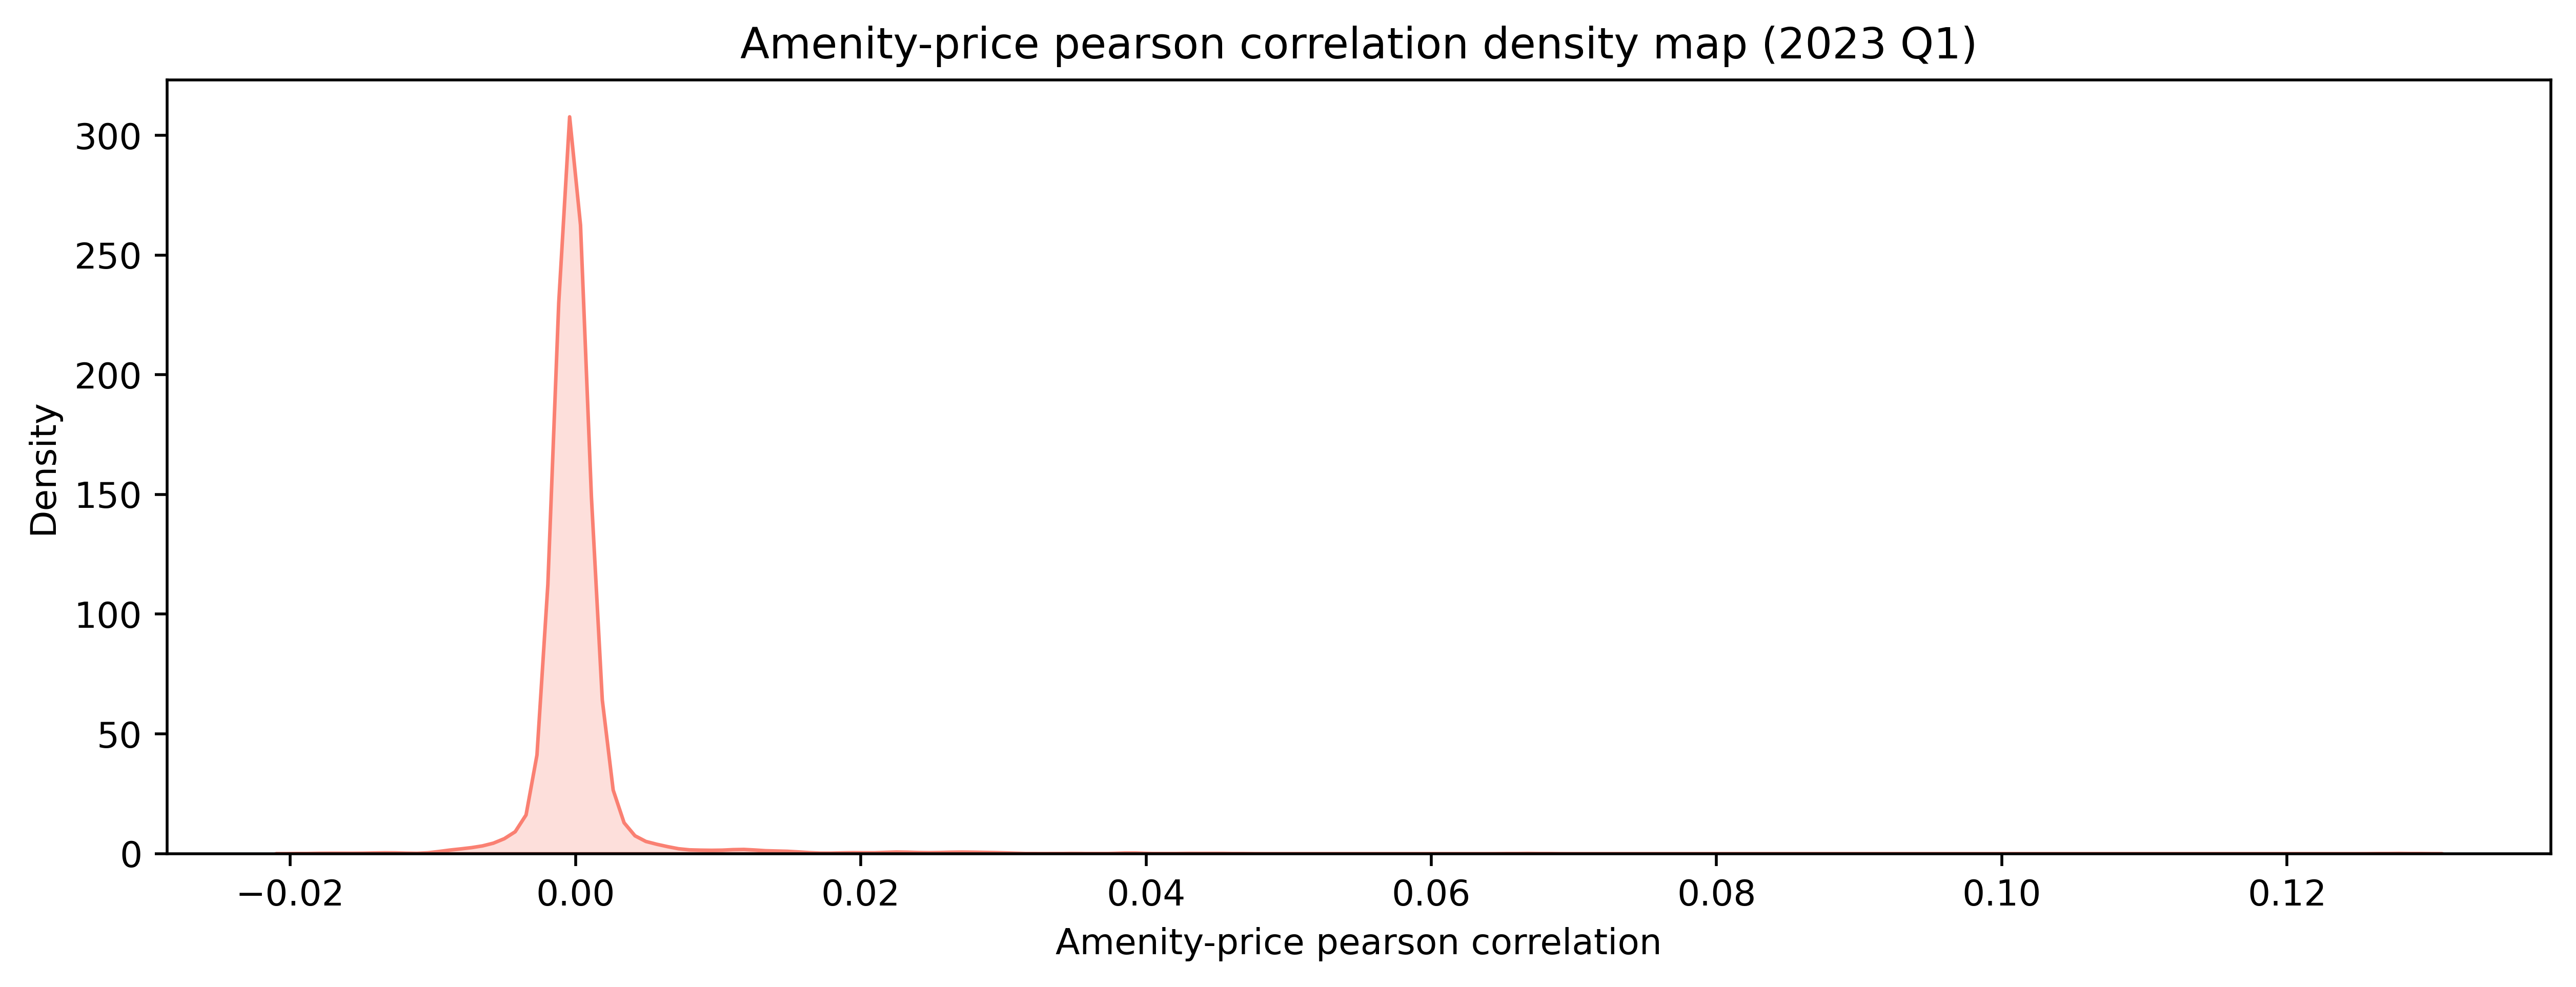

In [65]:
#Print the amenity-price pearson correlation density map
plt.figure(figsize=(12,4),dpi=500)
plt.xlabel('Amenity-price pearson correlation')
plt.title('Amenity-price pearson correlation density map (2023 Q1)')

sns.kdeplot(x=amenity_corr["price_usd"],color="salmon", shade=True);

In [66]:
# print out the summary statistics and the distribution of the amenity-price pearson correlation
amenity_corr["price_usd"].describe([0,0.25,0.05,0.75,0.8,0.85,0.9,0.95,0.99])

count    2173.000000
mean        0.000188
std         0.004699
min        -0.018010
0%         -0.018010
5%         -0.001988
25%        -0.000581
50%        -0.000339
75%         0.000039
80%         0.000196
85%         0.000540
90%         0.001010
95%         0.002665
99%         0.018815
max         0.127859
Name: price_usd, dtype: float64

In [67]:
print(f"""Min correlation: {amenity_corr["price_usd"].min()}""")
print(f"""Max correlation: {amenity_corr["price_usd"].max()}""")

Min correlation: -0.018009799036248924
Max correlation: 0.1278593144124035


__Observation__: 
 - Looking at the distribution of the correlations we can see that the data has a high kurtosis with a high peak centered around 0. This means that the great majority of the amenities may not have any correlation at all with the price. 
 - Looking at the min and max values of the correlations we can see that the highest correlated amenities (negatively and positively) also do not seem to have a high correlation with the price - since the values are not close to -1 or 1.
 
Based on this, I still decided to use some of the amenities which have at least some correlations (both negatively and positively), so I could include some information from the original _amenities_ column into training the model as they can have some __synergy__ with other features. For this I set the boundaries <= -0.01 and >= 0.01, in order to capture the highest correlated amenities and ignore the non-correlated ones.

In [68]:
# Filter the list of amenities based on the correlation boundaries: <=-0.01 and >=0.01
amenity_corr_filtered = amenity_corr[(amenity_corr["price_usd"] >= 0.01) | (amenity_corr["price_usd"] <= -0.01)]

print(f"""Total number of amenities: {len(amenity_corr_filtered)}""")

Total number of amenities: 47


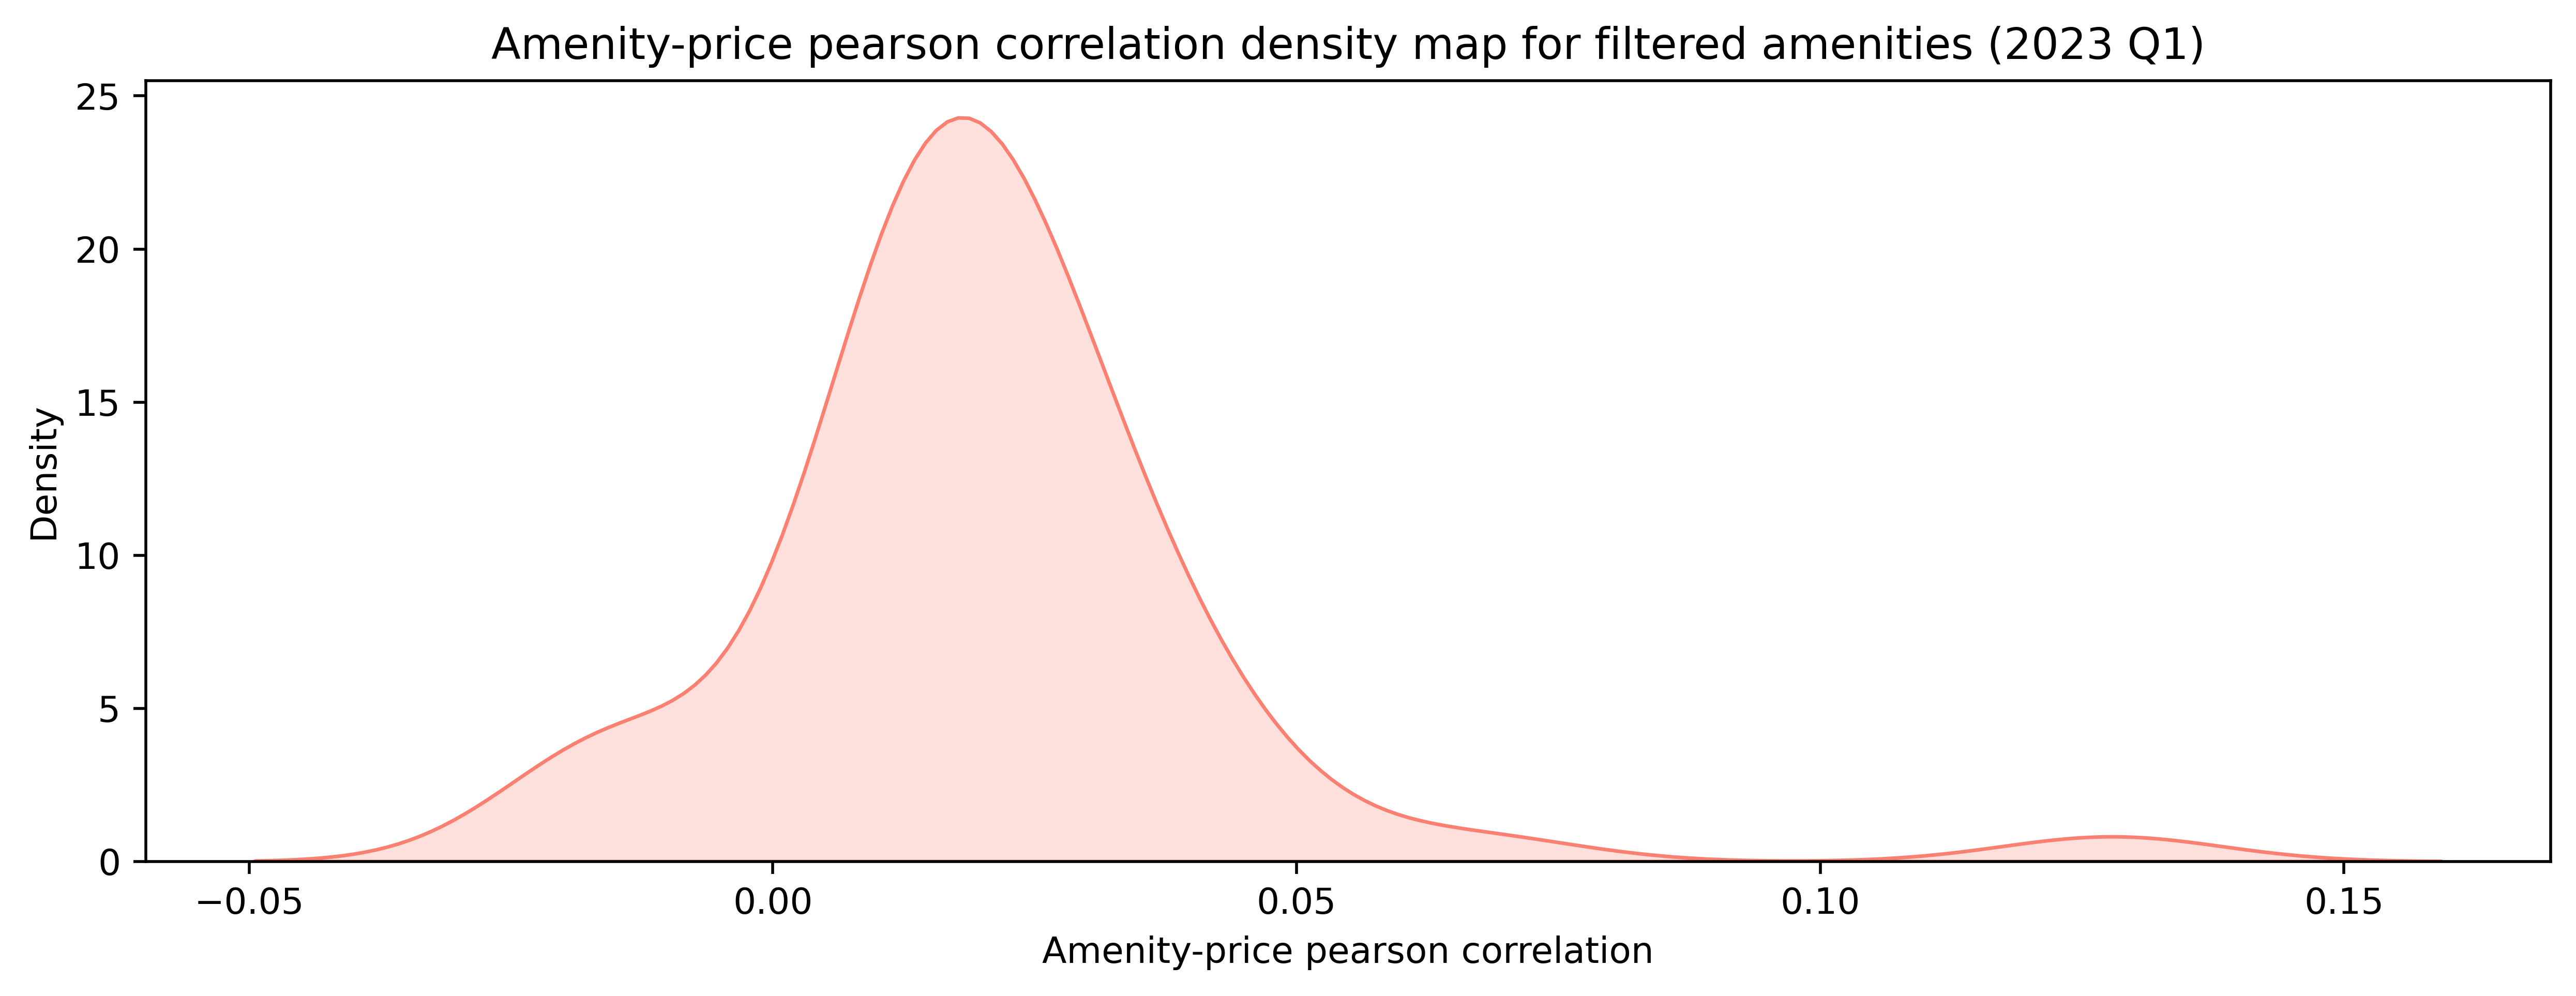

In [69]:
#Print the amenity-price pearson correlation density map for filtered amenities
plt.figure(figsize=(12,4),dpi=500)
plt.xlabel('Amenity-price pearson correlation')
plt.title('Amenity-price pearson correlation density map for filtered amenities (2023 Q1)')

sns.kdeplot(x=amenity_corr_filtered["price_usd"],color="salmon", shade=True);

__Observation:__ In this case I used 47 of the 2174 amenities to create a list of "interesting" amenities and created a dummy column with 1 or 0 for each amenity.

In [70]:
# create a list with the interesting amenities and clean some symbols from the names
amenity_ls = amenity_corr_filtered["index"].apply(lambda x: x.replace('\"',"").replace('[',"").replace(']',"").strip()).tolist()
print(amenity_ls)

['Air conditioning', 'BOSCH oven', 'BOSCH refrigerator', 'Bathtub', 'Bidet', 'Bosch electric stove', 'Clothing storage: dresser and walk-in closet', 'Dishwasher', 'Dryer \\u2013\\u00a0In unit', 'Dryer', 'Essentials', 'Free parking on premises', 'Free street parking', 'Gym', 'Hair dryer', 'Heating', 'Host greets you', 'Hot water', 'Hot water', 'Indoor fireplace', 'JBL sound system', 'Laundromat nearby', 'Lock on bedroom door', 'Lockbox', 'Oven', 'Pets allowed', 'Pool table', 'Pool', 'Private backyard \\u2013 Fully fenced', 'Private gym in building', 'Private patio or balcony', 'Private pool', 'Rituals body soap', 'Rituals conditioner', 'Rituals shampoo', 'River view', 'Self check-in', 'Ski-in/Ski-out', 'Smoking allowed', 'TV with standard cable', 'V\\u00e1rias  body soap', 'V\\u00e1rios  conditioner', 'Washer', 'Waterfront', 'Wifi \\u2013 20 Mbps', 'Bed linens', 'Cleaning products']


In [71]:
#define a function that counts the number of hits in the amenities column
def create_amenity_cols(row):
    """
    This function is meant to be applied into a pandas Dataframe column only.
    For each row of the specified column it checks if the element in the amenity list is contained in the "amenities" column.
    If yes it gets 1 otherwise 0.
    """
    return [1 if elem in row else 0 for elem in amenity_ls]

In [72]:
# apply the function on the "amenities" column
amenity_cols_df = target_df["amenities"].apply(lambda x: create_amenity_cols(x))
amenity_cols_df.head()

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Name: amenities, dtype: object

In [73]:
# create the dummy columns based on the results and append them to the target dataframe
target_df = pd.concat([target_df, pd.DataFrame(amenity_cols_df.tolist(), columns=amenity_ls)], axis=1)
target_df.iloc[:,-48:].tail()

bathrooms_shared  Air conditioning  BOSCH oven  BOSCH refrigerator  \
12405                 0                 0           0                   0   
12406                 0                 0           0                   0   
12407                 0                 0           0                   0   
12408                 0                 0           0                   0   
12409                 0                 0           0                   0   

       Bathtub  Bidet  Bosch electric stove  \
12405        0      1                     0   
12406        0      0                     0   
12407        0      0                     0   
12408        1      1                     0   
12409        1      1                     0   

       Clothing storage: dresser and walk-in closet  Dishwasher  \
12405                                             0           1   
12406                                             0           0   
12407                                             0           1   
12408                                             0           1   
12409                                             0           0   

       Dryer \u2013\u00a0In unit  Dryer  Essentials  Free parking on premises  \
12405                          0      0           1                         0   
12406                          0      1           1                         0   
12407                          0      0           1                         0   
12408                          0      0           1                         0   
12409                          0      1           1                         1   

       Free street parking  Gym  Hair dryer  Heating  Host greets you  \
12405                    0    0           1        0                1   
12406                    0    0           1        0                1   
12407                    0    0           1        1                0   
12408                    0    0           1        1                0   
12409                    1    0           1        0                1   

       Hot water  Hot water  Indoor fireplace  JBL sound system  \
12405          1          1                 0                 0   
12406          1          1                 0                 0   
12407          1          1                 1                 0   
12408          1          1                 0                 0   
12409          1          1                 0                 0   

       Laundromat nearby  Lock on bedroom door  Lockbox  Oven  Pets allowed  \
12405                  1                     0        0     0             0   
12406                  0                     0        0     1             0   
12407                  0                     0        1     1             0   
12408                  0                     0        0     1             0   
12409                  1                     0        0     1             1   

       Pool table  Pool  Private backyard \u2013 Fully fenced  \
12405           0     0                                     0   
12406           0     0                                     0   
12407           0     0                                     0   
12408           0     0                                     0   
12409           0     0                                     1   

       Private gym in building  Private patio or balcony  Private pool  \
12405                        0                         1             0   
12406                        0                         0             0   
12407                        0                         0             0   
12408                        0                         0             0   
12409                        0                         1             0   

       Rituals body soap  Rituals conditioner  Rituals shampoo  River view  \
12405                  0                    0                0           0   
12406                  0                    0                0

In [74]:
#print all columns in the dataframe
target_df.columns

Index(['id', 'host_id', 'host_is_superhost', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates',
       ...
       'Ski-in/Ski-out', 'Smoking allowed', 'TV with standard cable',
       'V\u00e1rias  body soap', 'V\u00e1rios  conditioner', 'Washer',
       'Waterfront', 'Wifi \u2013 20 Mbps', 'Bed linens', 'Cleaning products'],
      dtype='object', length=299)

In [75]:
# remove all unnecessary columns from target_df
drop_columns = list(listings_df_ls[0].columns)
relevant_colums = ["price_usd","accommodates","bedrooms","beds"]

for col in relevant_colums:
    drop_columns.remove(col)
    
target_df = target_df.drop(columns=drop_columns)

In [76]:
print(list(target_df.columns))

['accommodates', 'bedrooms', 'beds', 'price_usd', 'AVer-o-Mar, Amorim e Terroso', 'Agrela', 'Aguiar de Sousa', 'Aguçadoura e Navais', 'Aldoar, Foz do Douro e Nevogilde', 'Alfena', 'Alvarelhos e Guidões', 'Alvarenga', 'Anta e Guetim', 'Arcozelo', 'Areias, Sequeiró, Lama e Palmeira', 'Argoncilhe', 'Arouca e Burgo', 'Arões', 'Avintes', 'Azurara', 'Baguim do Monte (Rio Tinto)', 'Bagunte, Ferreiró, Outeiro Maior e Parada', 'Balazar', 'Baltar', 'Bonfim', 'Bougado (São Martinho e Santiago)', 'Cabreiros e Albergaria da Serra', 'Caldas de São Jorge e de Pigeiros', 'Campanhã', 'Campo e Sobrado', 'Canedo, Vale e Vila Maior', 'Canelas', 'Canelas e Espiunca', 'Canidelo', 'Carregosa', 'Carreira e Refojos de Riba de Ave', 'Castêlo da Maia', 'Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, Vitória', 'Cepelos', 'Cesar', 'Cete', 'Chave', 'Cidade da Maia', 'Coronado (São Romão e São Mamede)', 'Covelas', 'Cristelo', 'Custóias, Leça do Balio e Guifões', 'Duas Igrejas', 'Ermesinde', 'Escariz', 'Espinho', 'Este

#### <a href="#top">Back to top</a>

<a id='section4_1_6'></a>
### Target: price
This is not per se a step of feature engineering but a very important one nonetheless. Above, in the section of <a href="#section3_1">Data Distribution</a>, it is possible to see how extremely skewed the distribution of price is. If this is not treated it can have a negative impact on the performance.

In this case I decided to remove the extremely expensive listings from the list for various reasons:
1. No matter how I transform the data, for example by using the log price instead, this will always influence the results because some outliers are too extreme.
2. Although this may be important information, we might not be able to explain these extreme prizes just with the data at hand. For example, an important factor missing would be the size of the listing.
3. The goal is to predict a listing that is somehow realistic in a normal context. I personaly think that after a certain threshold of luxury you are free to dictate the price and don't need to reference on any other listing.

I simply decided to cut off everything that is above 500 USD and discard it. 

In [77]:
droped_listings = target_df[target_df["price_usd"] > 500]

print("Number of discarded listings:{}".format(len(droped_listings)))
print("Percentage of discarded listings:{}%".format(round(len(droped_listings)/len(target_df)*100, 2)))

Number of discarded listings:87
Percentage of discarded listings:0.7%


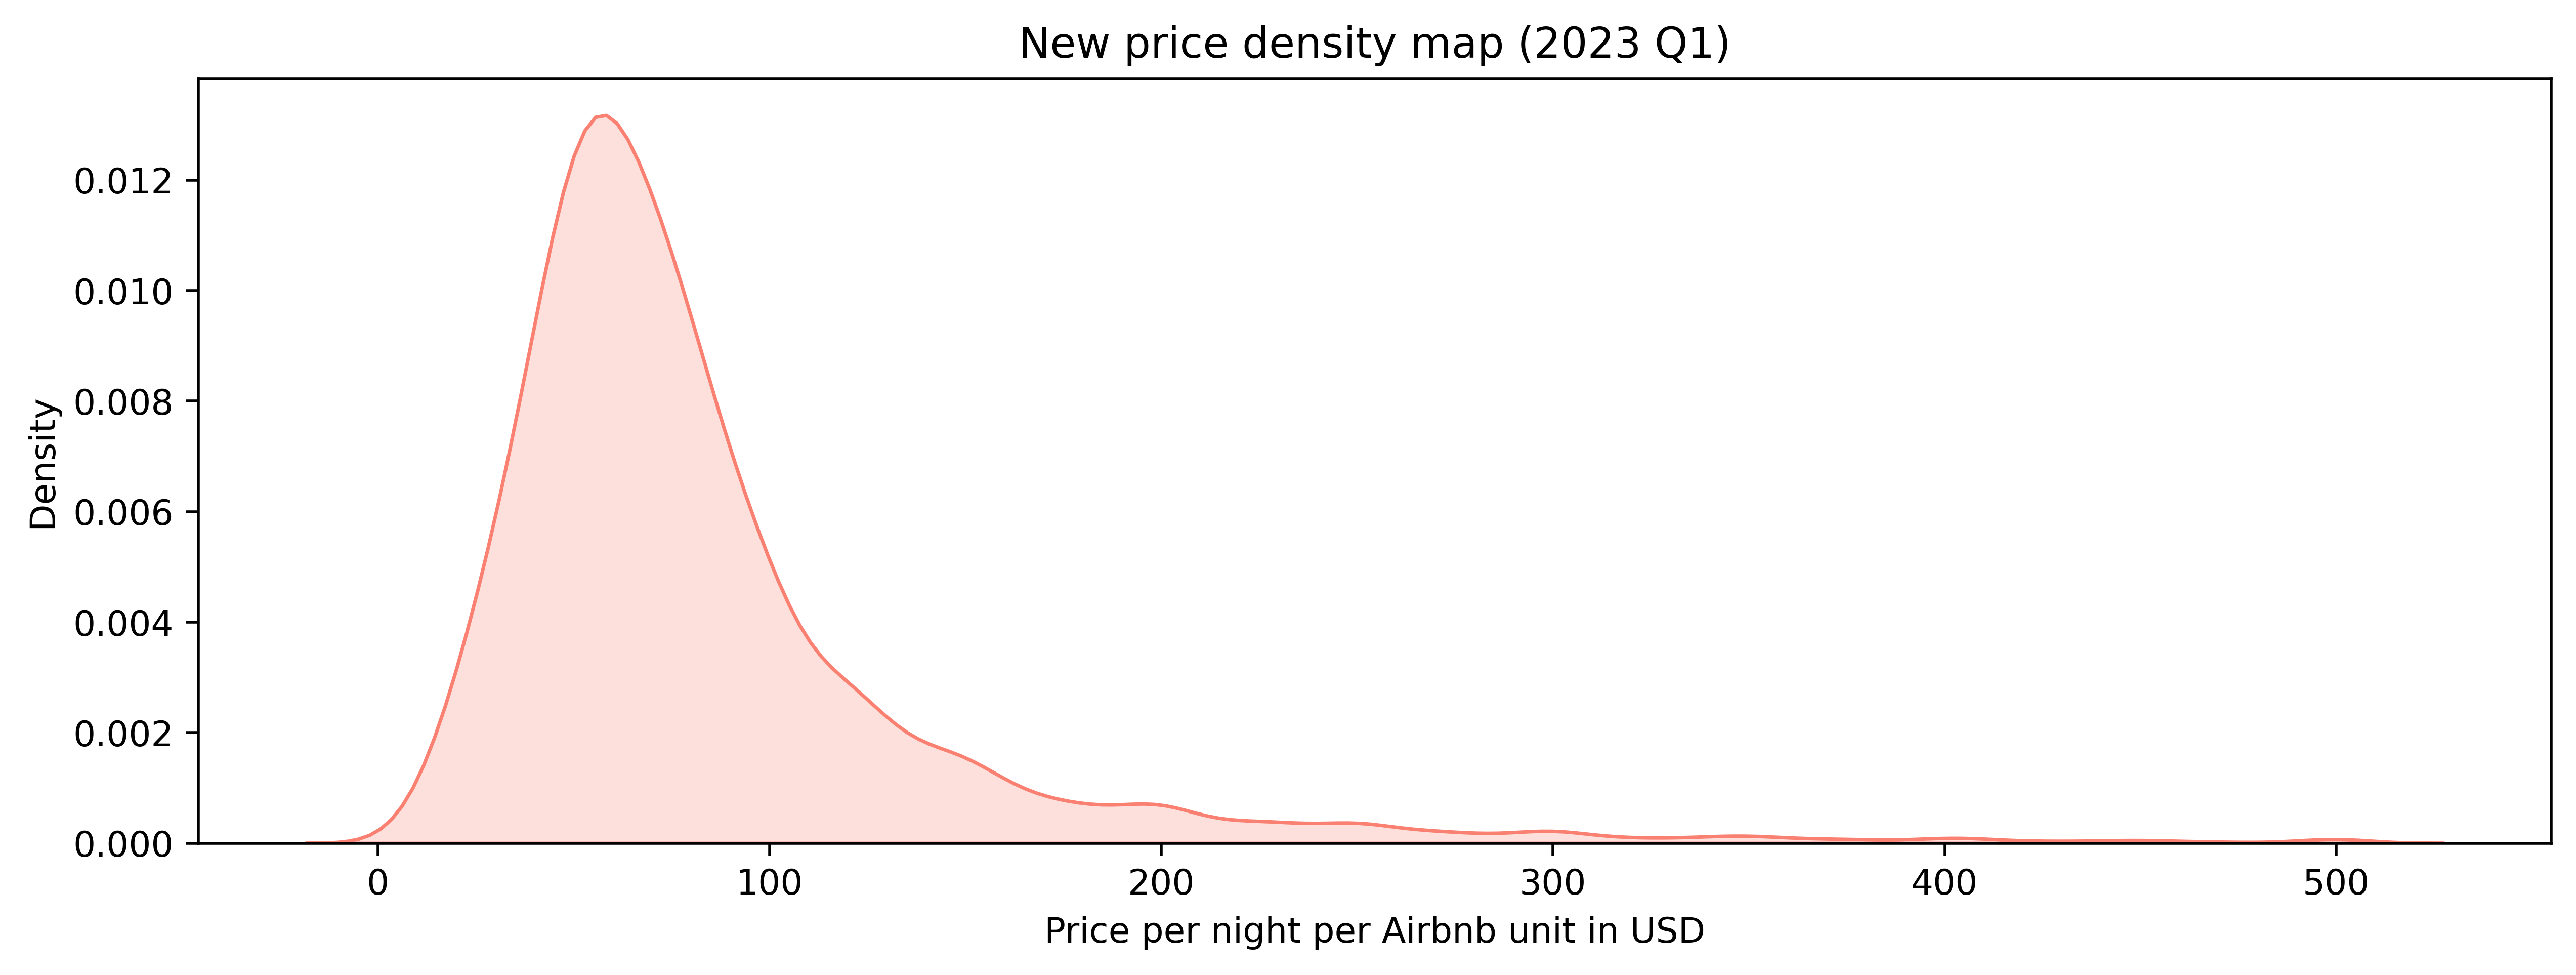

In [78]:
#Remove all listings about 500 USD
target_df = target_df[target_df["price_usd"] <= 500]

#Print the price distribution
plt.figure(figsize=(12,4),dpi=500)
plt.xlabel('Price per night per Airbnb unit in USD')
plt.title('New price density map (2023 Q1)')

sns.kdeplot(x=target_df["price_usd"],color="salmon", shade=True);

In [79]:
# print out the summary statistics and the distribution of the frequency of amenities
target_df["price_usd"].describe()

count    12323.000000
mean        84.169520
std         60.424838
min          9.000000
25%         50.000000
50%         69.000000
75%         96.000000
max        500.000000
Name: price_usd, dtype: float64

__Observation:__ Looking at the distribution it is still possible to see a light skewness but it is something I was willing to accept and tried to mitigate using cross validation.

#### <a href="#top">Back to top</a>

<a id='section4_2'></a>
## 4.2 Training
In this section I trained tree different algorithms with increasing complexity: 
1. Linear Regression (using Elastic Net)
2. Random Forest
3. Gradient Boosting

Further steps used for training:
 - train-validation-test split withn a hold-out dataset for final performance evaluation.
 - standard scaler to scale the data.
 - parameter grid search to train with multiple parameter combinations an search for the best combination.

In [80]:
# create the train-test-eval splits
X = target_df.drop("price_usd", axis=1)
y = target_df["price_usd"]

X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.3, random_state=10)
X_validation, X_holdout, y_validation, y_holdout = train_test_split(X_other, y_other, test_size=0.5, random_state=10)

print("Size of X_train: {}".format(len(X_train)))
print("Size of X_validation: {}".format(len(X_validation)))
print("Size of X_holdout: {}".format(len(X_holdout)))
print("----------------------")
print("Size of y_train: {}".format(len(y_train)))
print("Size of y_validation: {}".format(len(y_validation)))
print("Size of y_holdout: {}".format(len(y_holdout)))

Size of X_train: 8626
Size of X_validation: 1848
Size of X_holdout: 1849
----------------------
Size of y_train: 8626
Size of y_validation: 1848
Size of y_holdout: 1849


In [81]:
#compare the distributions of the target variable on the splits
print("Summary statistics of y_train:")
y_train.describe()

Summary statistics of y_train:


count    8626.000000
mean       84.309993
std        61.022166
min         9.000000
25%        50.000000
50%        69.000000
75%        96.000000
max       500.000000
Name: price_usd, dtype: float64

In [82]:
print("Summary statistics of y_other:")
y_other.describe()

Summary statistics of y_other:


count    3697.000000
mean       83.841764
std        59.014467
min         9.000000
25%        50.000000
50%        69.000000
75%        96.000000
max       500.000000
Name: price_usd, dtype: float64

__Observation:__ It is possible to see that both splits are well balanced in terms of the skewness of the target variable.

In [83]:
# Scale the features
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_validation = scaler.transform(X_validation)
X_holdout = scaler.transform(X_holdout)

Model: Elastic Net
Best Parameters: {'model__alpha': 0.5, 'model__fit_intercept': True, 'model__l1_ratio': 0.9, 'model__normalize': False}
Number of best parameter combination: 17
Best Train Set RMSE: 45.50246887411459
Best Test Set RMSE: 46.74233418040003


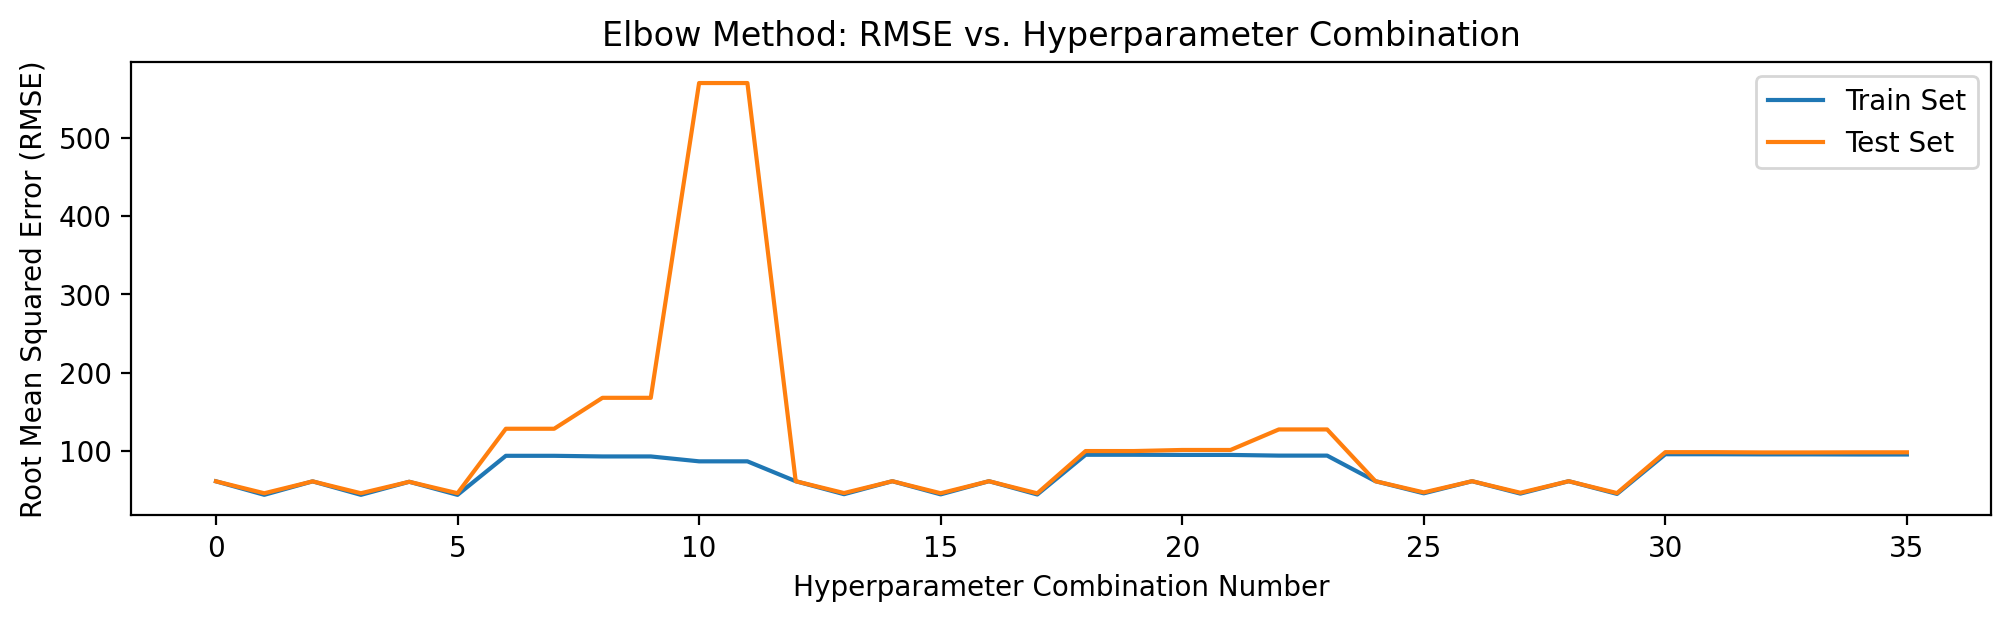

--------------------------------------------------------------------------------------------------------------------
Model: Random Forest
Best Parameters: {'model__max_depth': 20, 'model__n_estimators': 300, 'model__random_state': 42}
Number of best parameter combination: 14
Best Train Set RMSE: 43.11811571611371
Best Test Set RMSE: 43.99554836845516


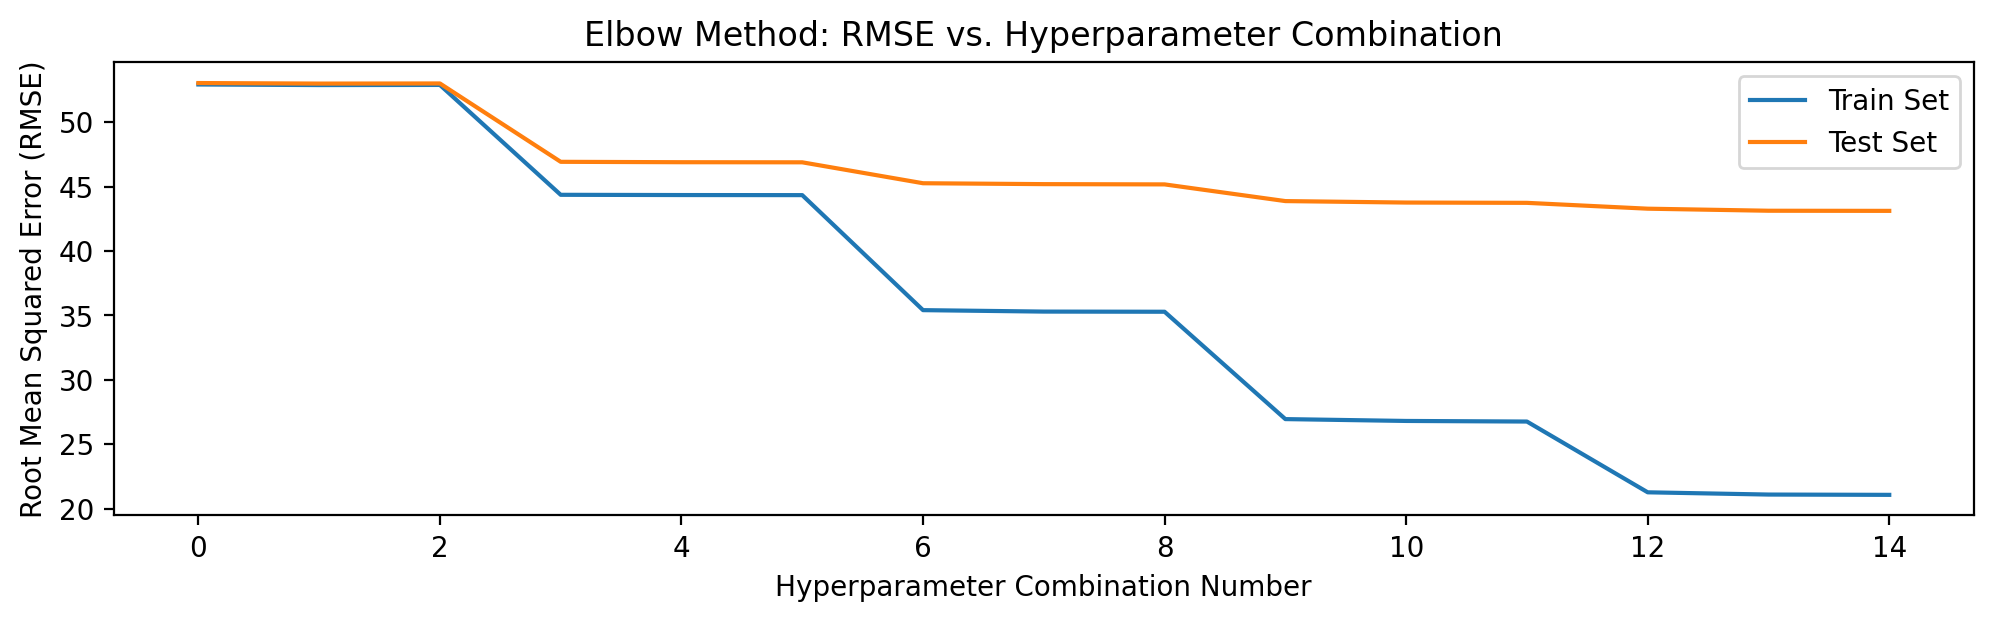

--------------------------------------------------------------------------------------------------------------------
Model: Gradient Boosting
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
Number of best parameter combination: 7
Best Train Set RMSE: 43.40754997538826
Best Test Set RMSE: 45.33596623902469


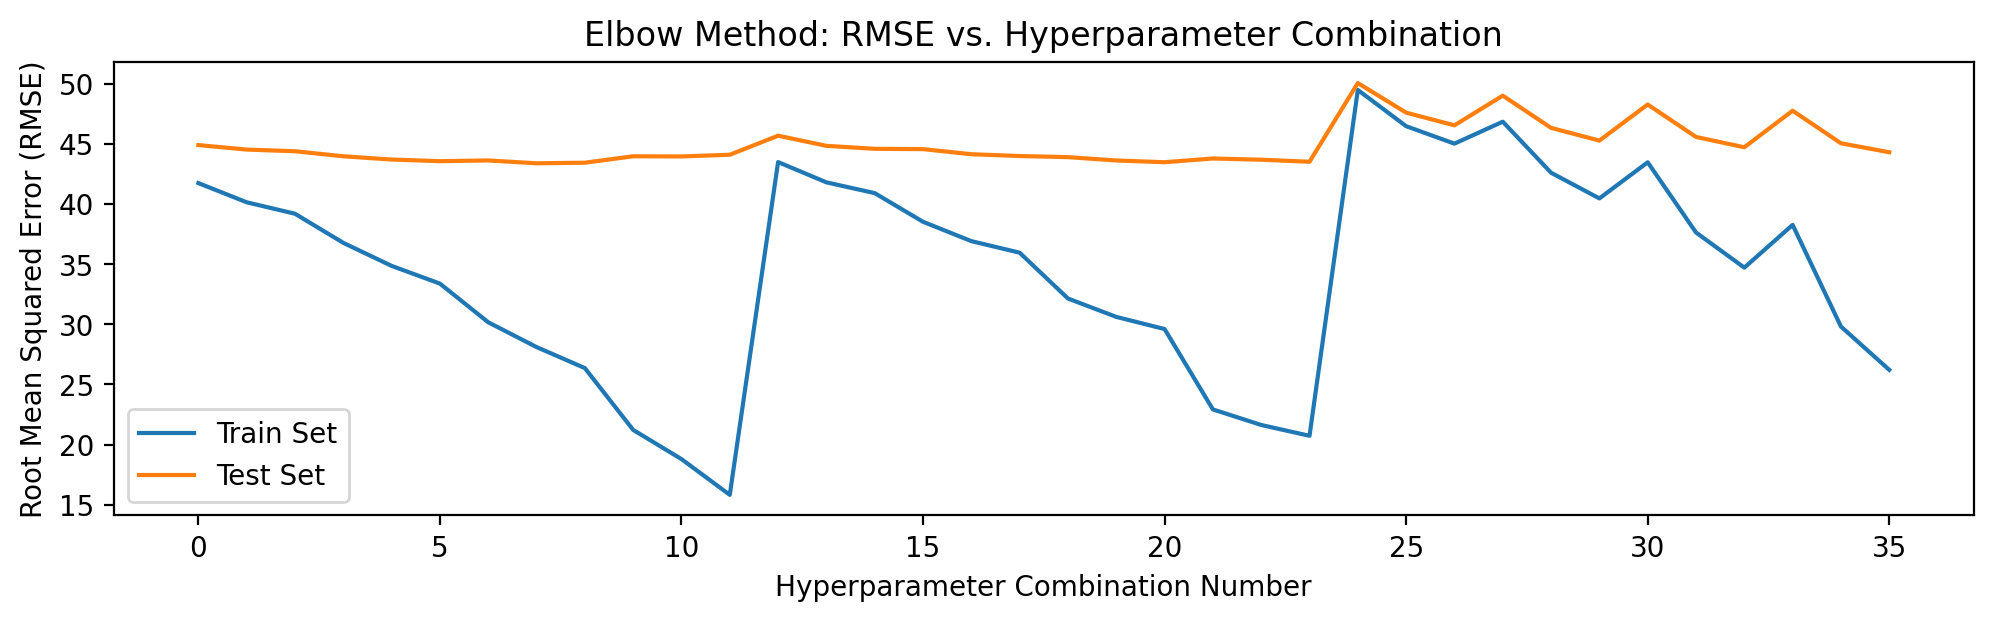

--------------------------------------------------------------------------------------------------------------------


In [84]:
#########################################################################
# BUILD A ML PIPELINE
#########################################################################
# Create a dictionary of ml models with their respective hyperparameters
models = {
    "Elastic Net": {
        "model": ElasticNet(),
        "param_grid": {
            'model__alpha': [0.1, 0.5, 1.0],  
            'model__l1_ratio': [0.1, 0.5, 0.9], 
            'model__fit_intercept': [True, False],
            'model__normalize': [True, False]

        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "param_grid": {
            "model__n_estimators": [100, 200, 300],
            "model__max_depth": [1, 5, 10, 15, 20],
            "model__random_state": [42]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(),
        "param_grid": {
            "model__n_estimators": [100, 200, 300],
            "model__learning_rate": [0.1, 0.05, 0.01],
            "model__max_depth": [3, 5, 7, 10]
        }
    }
}

# Iterate over the models and perform grid search with cross-validation
for model_name, model_config in models.items():
    # Define the pipeline with preprocessing and model
    pipeline = Pipeline(steps=[("model", model_config["model"])])

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(pipeline, 
                               param_grid=model_config["param_grid"], 
                               cv=5, 
                               scoring="neg_mean_squared_error", 
                               return_train_score=True)
    
    grid_search.fit(X_train, y_train)
    
    # Get the best model and its evaluation metric score
    best_model = grid_search.best_estimator_
    best_score = np.sqrt(grid_search.best_score_ * -1) # Multiply by -1 to convert neg_mean_squared_error to MSE
    
    # Predict on the test set and evaluate the performance
    y_pred = best_model.predict(X_validation)
    
    # Evaluate the performance altogether
    rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
    
    # Collect all the results to plot the errors
    parameters = grid_search.cv_results_["params"]
    rmse_train = np.sqrt(grid_search.cv_results_["mean_train_score"]*-1) # Multiply by -1 to convert neg_mean_squared_error to MSE
    rmse_eval = np.sqrt(grid_search.cv_results_["mean_test_score"]*-1) # Multiply by -1 to convert neg_mean_squared_error to MSE
    
    # Print the results
    print(f"Model: {model_name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Number of best parameter combination: {parameters.index(grid_search.best_params_)}")
    print(f"Best Train Set RMSE: {best_score}")
    print(f"Best Test Set RMSE: {rmse}")

    # Plot the RMSE values for different hyperparameter combinations
    plt.figure(figsize=(12, 3),dpi=200)
    plt.plot(range(len(rmse_train)), rmse_train, label="Train Set")
    plt.plot(range(len(rmse_eval)), rmse_eval, label="Test Set")
    plt.xlabel("Hyperparameter Combination Number")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.title("Elbow Method: RMSE vs. Hyperparameter Combination")
    plt.legend()
    plt.show()
    print("--------------------------------------------------------------------------------------------------------------------");       

#### <a href="#top">Back to top</a>

<a id='section4_3'></a>
## 4.3 Evaluation

__Interpretation of the results__

By looking at the results of the root mean squared error (RMSE) for the train and test sets we can see that all 3 algorithms achieved a similar performance. However, looking at the line charts we can the that __Random Forest__ actually performed better in terms of the variability of the errors for the two data sets. I therefore decided to use it with the suggested best hyperparameter combination since it is when the RMSE from the test set does not improve anymore and also does not detiorate right after.

A RMSE of ca. 43 USD, which corresponds to the standard deviation of the predictions, in this context is not great but considering the type of data available it is also not that bad. We can see that it is below the standard deviation of the price distribution (ca. 60 USD), which may indicate that it could learn some patterns, but of course it still has some variation. That could be expected taking in consideration the limitations of the data: some important features are missing, like if it is a luxury/very basic unit, the size and other subjective aspects like natural light, taste of the decoration, themes, etc. Also, the prices per nights may be subjected to seasonality, since higher demands could influence the prices.

All in all, it looks like an "ok" model, but we need to investigate more details of predicted values and the residuals to see if anything is obviously wrong.

In [85]:
# Train random forest using the best hyperparameter combination from the gridsearch

# Create a Random Forest regressor
rf = RandomForestRegressor(max_depth=20, n_estimators=300, random_state=42)

# Fit the model to your data
rf.fit(X_train, y_train)

# Predict on X_validation
y_pred = rf.predict(X_validation)

# Calculate the rmse
rmse = np.sqrt(mean_squared_error(y_validation, y_pred))

print(f"RMSE: {rmse}")

RMSE: 43.99554836845516


In [86]:
# Get the feature importances from the model
importances = rf.feature_importances_

# Create a dataframe to store the feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the dataframe by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Print the features with more importance in the model
feature_importances_df.head()

Feature  Importance
1            bedrooms    0.277964
230         bathrooms    0.095951
0        accommodates    0.083348
2                beds    0.031196
231  bathrooms_shared    0.026592

In [87]:
nr_zero_importance = len(feature_importances_df[feature_importances_df['Importance'] == 0])
print(f"The are {nr_zero_importance} features ({round(nr_zero_importance/len(feature_importances_df)*100,1)}%) with 0 importance in this model.")

The are 15 features (5.4%) with 0 importance in this model.


__Observation:__ Even though there are some features which seem to have no importance for this model i decided to keep them because it is not a huge amount compared to the overall number.

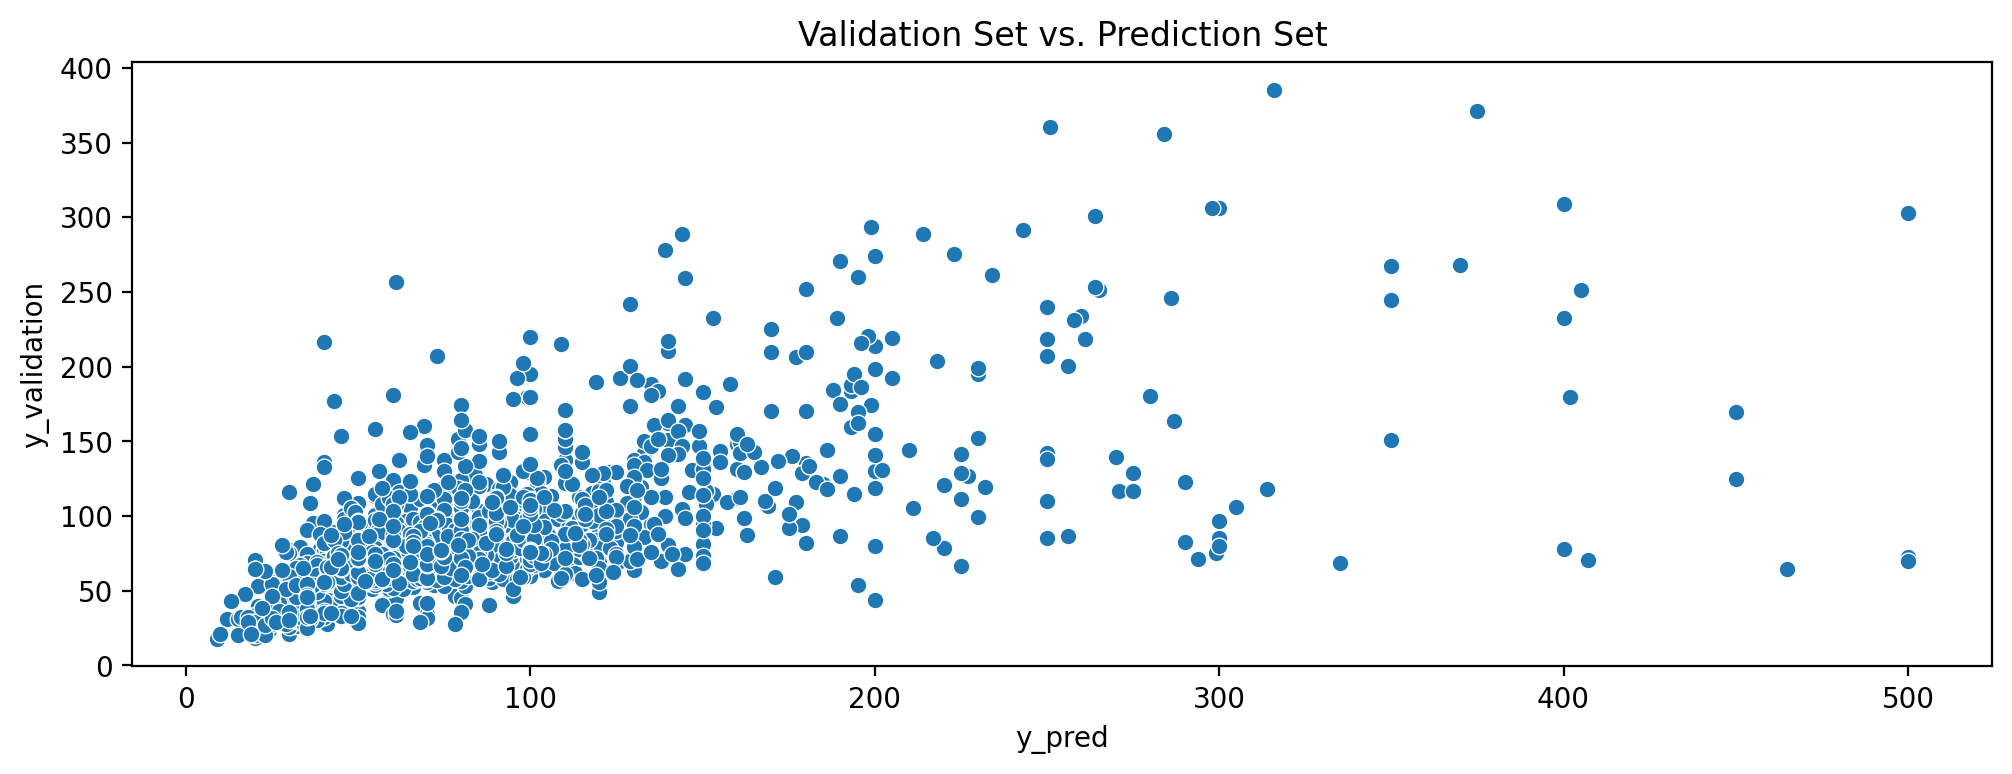

In [88]:
#plot the predictions againts the validation set 
plt.figure(figsize=(12,4),dpi=200)
plt.xlabel('y_pred')
plt.ylabel('y_validation')
plt.title('Validation Set vs. Prediction Set')

sns.scatterplot(x=y_validation, y=y_pred);

__Observation__: Although there is not a perfect fit, the differences between the predictions and the validation set seem to have a positive trend with some variation.

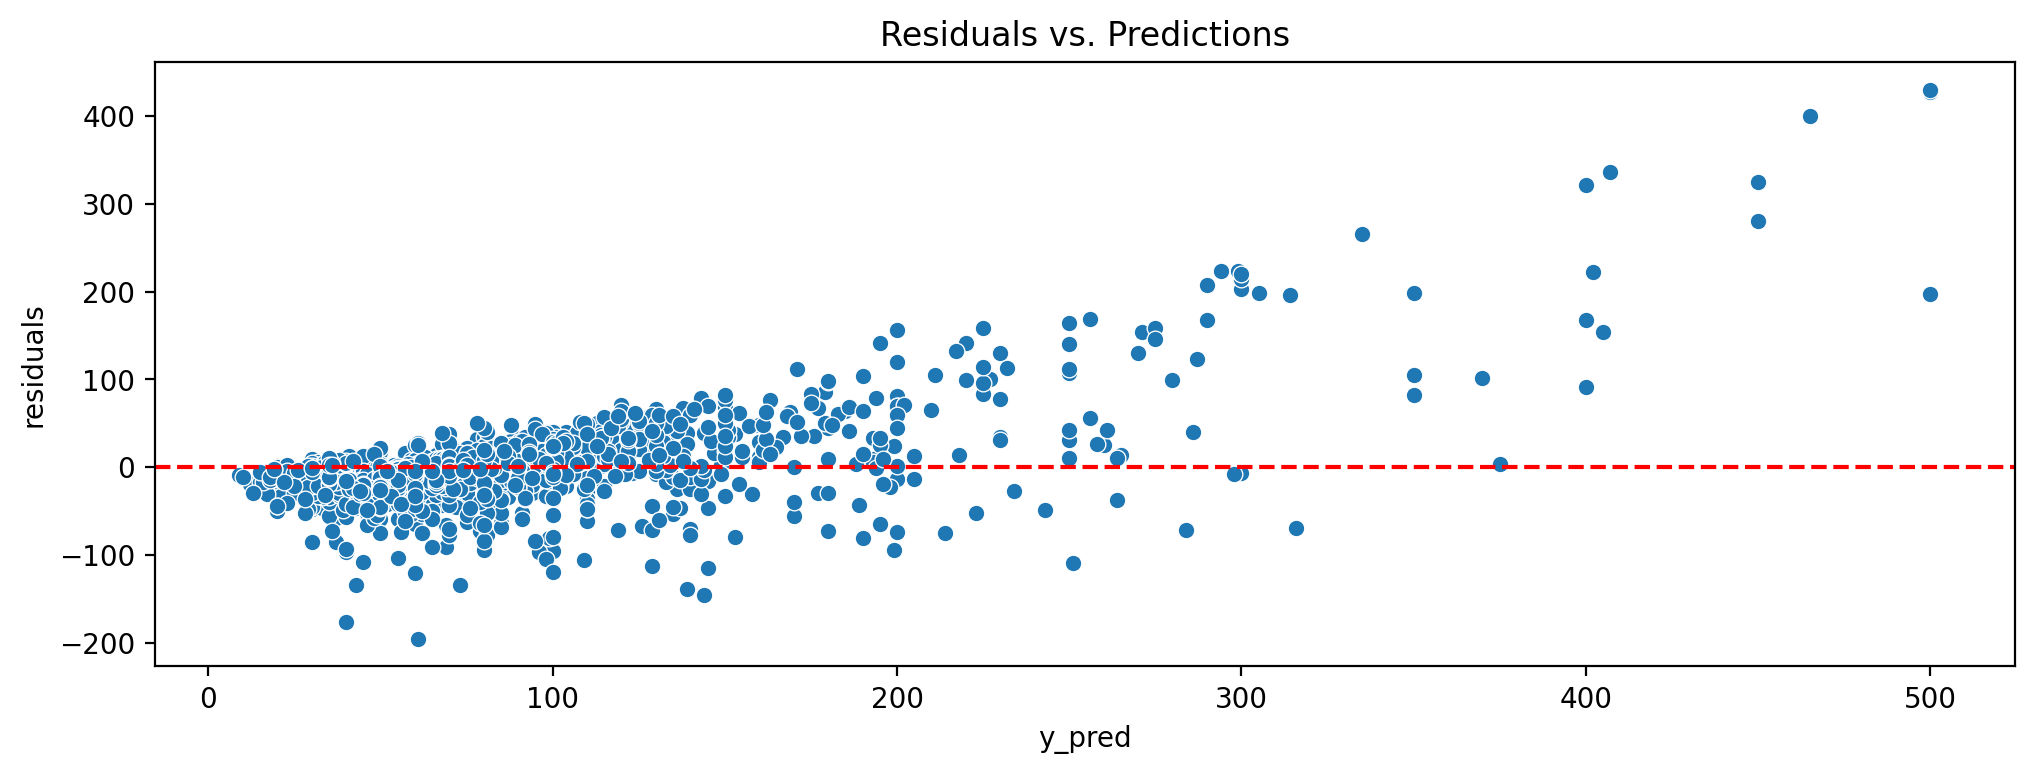

In [89]:
#calculate the residuals
residuals = y_validation - y_pred

#plot the residuals agains the predictions
plt.figure(figsize=(12,4),dpi=200)
plt.xlabel('y_pred')
plt.ylabel('residuals')
plt.title('Residuals vs. Predictions')

sns.scatterplot(x=y_validation, y=residuals)
plt.axhline(y=0, color="red", ls="--");

__Observation__: In a perfect scenario we would expect to see the data points randomly scattered across the field with similar number above and below the red line. In this case there is some concentration, which may be an indication that our model is not that good. This however is a matter of interpretability so I decided to accept it, because based on the data at hand and the RMSE, there will probably be no better model for this scenario without overfitting the data. 

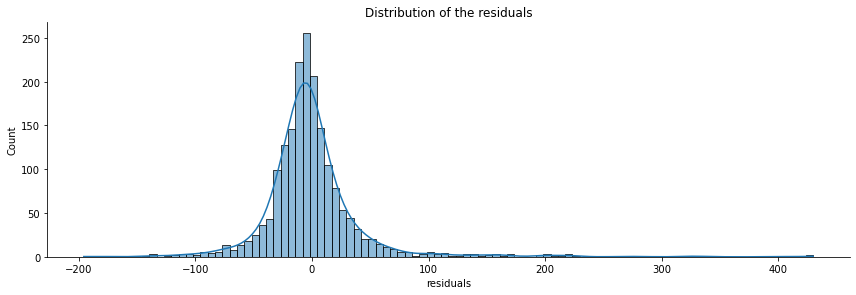

In [90]:
sns.displot(residuals, bins=100, kde=True, height=4, aspect=3)
plt.xlabel('residuals')
plt.title('Distribution of the residuals');

__Observation__: The distribution of the residuals follows a normal distribution with a slight skewness so nothing bad here.

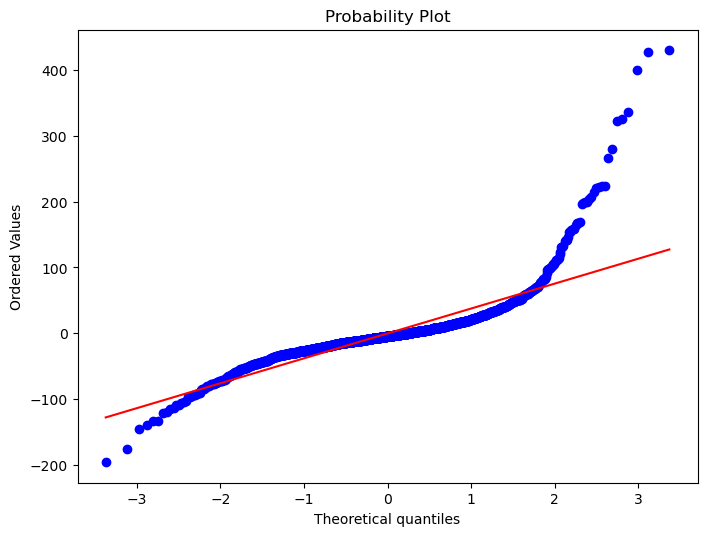

In [91]:
# Plot the probabilty plot for the residuals
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
sp.stats.probplot(residuals, plot=ax);

__Observation:__ The skewness in the distribution of the residuals is more evident on this probability plot, where we would expect in a perfect scenario that all the dots would follow the red line.

Now it is time to get the final evaluation report based on the hold-out set:

In [92]:
# Predict on X_holdout
y_final_pred = rf.predict(X_holdout)

# Calculate the mae and rmse
mae = median_absolute_error(y_holdout, y_final_pred)
rmse = np.sqrt(mean_squared_error(y_holdout, y_final_pred))

print(f"Final MAE: {mae}")
print(f"Final RMSE: {rmse}")

Final MAE: 15.482281605985193
Final RMSE: 41.316146729060044


Based on the analyses above it is possible to see that this is not a very good model but also not extremely wrong and probably could be used as a reference to set a price per night on a new Airbnb unit. The variation of 41 USD could be taken into account to exploit higher prices ranges depending of other factors.

#### <a href="#top">Back to top</a>

<a id='section4_4'></a>
## 4.4 Deployment
To deploy the model, I will re-train it using the whole data set and then persist it as a pickle file.

In [93]:
# Load the features and the target variable
X = target_df.drop("price_usd", axis=1)
y = target_df["price_usd"]

# Scale the features (although not necessary for this model I did it to keep consistency with hyperparameter tunning)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Create a Random Forest regressor
final_model = RandomForestRegressor(max_depth=20, n_estimators=300, random_state=42)

# Fit the model to your data
final_model.fit(X, y)

RandomForestRegressor(max_depth=20, n_estimators=300, random_state=42)

In [94]:
# Persist the model
joblib.dump(final_model, "model\\airbnb_price_2023.pkl")

# Persist columns as well
joblib.dump(list(target_df.drop("price_usd", axis=1)), "model\\columns_airbnb_price_2023.pkl")

['model\\columns_airbnb_price_2023.pkl']

#### <a href="#top">Back to top</a>

<a id='section4_5'></a>
## 4.5 Prediction
In this stage I will try and predict the price of a new Airbnb listing using the pickle file.

In [95]:
# load the model columns
model_columns = joblib.load("model\\columns_airbnb_price_2023.pkl")

# load the model
loaded_model = joblib.load("model\\airbnb_price_2023.pkl")

In [96]:
# create a pandas Series with 0s
input_data = pd.Series(0, index=model_columns)
input_data

accommodates                    0
bedrooms                        0
beds                            0
AVer-o-Mar, Amorim e Terroso    0
Agrela                          0
                               ..
Washer                          0
Waterfront                      0
Wifi \u2013 20 Mbps             0
Bed linens                      0
Cleaning products               0
Length: 279, dtype: int64

Now I can update the features where it is relevant for the prediction:

In [97]:
# Create parameters of the listing in question for prediction
target_listing = {"accommodates":5,
                  "bedrooms":2,
                  "beds":3,
                  "Canidelo":1,
                  "superhost_false":1,
                  "Entire home/apt":1,
                  "bathrooms":2,
                  "Air conditioning":1,
                  "Entire home/apt type":1,
                  "BOSCH oven":1,
                  "BOSCH refrigerator":1,
                  "Clothing storage: dresser and walk-in closet":1,
                  "Dishwasher":1,
                  "Essentials":1,
                  "Free parking on premises":1,
                  "Hot water":1,
                  "Lockbox":1,
                  "Private patio or balcony":1,
                  "Self check-in":1,
                  "TV with standard cable":1,
                  "Washer":1,
                  "Oven":1,
                  "Bed linens":1,
                  "Cleaning products":1}

In [98]:
# update the input data according to the listing:
for feature, value in target_listing.items():
    input_data[feature] = value

In [99]:
input_data

accommodates                    5
bedrooms                        2
beds                            3
AVer-o-Mar, Amorim e Terroso    0
Agrela                          0
                               ..
Washer                          1
Waterfront                      0
Wifi \u2013 20 Mbps             0
Bed linens                      1
Cleaning products               1
Length: 279, dtype: int64

In [100]:
# Scale the features to match what the model expects
X = input_data.values.reshape(1, -1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# predict the price per night for this unit
loaded_model.predict(X)

array([62.91214495])

For this particular listing the the model predicted an average price per night of about 63 USD. We need to keep in mind that this value could potentially have a deviation of 41 USD, so depending on various other factors not recorded in this dataset, we could change the value according to the deviation and still be in conformity with what the other listings are offering.

#### <a href="#top">Back to top</a>